## Import Packages

In [1]:
import os
import yaml
import math
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.io

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

## Parameters

In [3]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1904_C7_cond_1_HTO"
workflow_id = "08778704-c763-4145-a951-b8af53cc45cc"
path_data = os.path.join("./hashtag/", sample_name, workflow_id)

## Run Report

In [4]:
!cat $path_data/report/run_report.yaml

Date: 2020-07-17
Running time: 1.0 hour, 25.0 minutes, 15.75 seconds
CITE-seq-Count Version: 1.4.3
Reads processed: 56902257
Percentage mapped: 94
Percentage unmapped: 6
Uncorrected cells: 3
Correction:
	Cell barcodes collapsing threshold: 1
	Cell barcodes corrected: 95210
	UMI collapsing threshold: 1
	UMIs corrected: 477024
Run parameters:
	Read1_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/08778704-c763-4145-a951-b8af53cc45cc/call-TrimR1/R1.fastq.gz
	Read2_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/08778704-c763-4145-a951-b8af53cc45cc/call-TrimR2/R2.fastq.gz
	Cell barcode:
		First position: 1
		Last position: 16
	UMI barcode:
		First position: 17
		Last position: 28
	Expected cells: 0
	Tags max errors: 2
	Start trim: 0


In [5]:
with open(os.path.join(path_data, "report/run_report.yaml"), "rt") as fin:
    # report file contains tabs
    # run_report = yaml.load(fin, Loader=yaml.FullLoader)        
    run_report = fin.read().replace("\t", "  ")
    run_report = yaml.load(run_report, Loader=yaml.FullLoader)

## Load Counts

### UMI Counts

In [6]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "umis/matrix.mtx.gz")
)

In [7]:
barcodes = pd.read_csv(
    os.path.join(path_data, "umis/barcodes.tsv.gz"),
    sep="\t",
    index_col=0,
    compression="gzip",
    header=None
)

In [8]:
barcodes.index.name = "cell_barcodes"

In [9]:
features = pd.read_csv(
    os.path.join(path_data, "umis/features.tsv.gz"),
    sep="\t",
    index_col=0,
    compression="gzip",
    header=None
)

In [10]:
features.index.name = None

In [11]:
# exclude unmapped
adata = sc.AnnData(
    mtx.T.tocsr()[:, :-1],
    dtype="int64",
    obs=barcodes,
    var=features.iloc[:-1]
)

In [12]:
adata.obs["unmapped_umi"] = mtx.T.toarray()[:, -1]

In [13]:
adata.obs

unmapped_umi
cell_barcodes                 
AATTCCTCATAGAATG            94
AACCTTTTCGTAGGGA           182
TACACCCGTTTCGCTC           107
ACACTGACACCAGTTA             4
AAAGTCCGTGCCTGAC           131
...                        ...
GCGAGAATCACCATGA           151
CTAGGTACAAGGCGTA           122
CTGCGAGTCTGAATCG            72
AGGCCACGTAATGCTC           111
TCGTGGGAGGCGAAGG            76

[2572 rows x 1 columns]

In [14]:
adata.var

Empty DataFrame
Columns: []
Index: [A0301-ACCCACCAGTAAGAC, A0302-GGTCGAGAGCATTCA, A0303-CTTGCCGCATGTCAT, A0304-AAAGCATTCTTCACG, A0305-CTTTGTCTTTGTGAG, A0306-TATGCTGCCACGGTA]

In [15]:
adata.to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
AATTCCTCATAGAATG                   4506                      1   
AACCTTTTCGTAGGGA                      8                      7   
TACACCCGTTTCGCTC                   6297                      0   
ACACTGACACCAGTTA                      1                      0   
AAAGTCCGTGCCTGAC                   6539                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                      7                     17   
CTAGGTACAAGGCGTA                     11                      8   
CTGCGAGTCTGAATCG                      7                      5   
AGGCCACGTAATGCTC                      3                     15   
TCGTGGGAGGCGAAGG                      7                      3   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
AATTCCTCATAGAATG                      2                      1   
AACCTTTTCGTAGGGA                      0                      1   
TACACCCGTTTCGCTC                      1                      0   
ACACTGACACCAGTTA                      0                      0   
AAAGTCCGTGCCTGAC                      1                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                      0                      0   
CTAGGTACAAGGCGTA                      0                      4   
CTGCGAGTCTGAATCG                      0                      0   
AGGCCACGTAATGCTC                      0                      1   
TCGTGGGAGGCGAAGG                      0                      2   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
AATTCCTCATAGAATG                      0                      8  
AACCTTTTCGTAGGGA                      0                   6255  
TACACCCGTTTCGCTC                      0                      8  
ACACTGACACCAGTTA                      0                      0  
AAAGTCCGTGCCTGAC                      1                     25  
...                                 ...                    ...  
GCGAGAATCACCATGA                      0                   6611  
CTAGGTACAAGGCGTA                      1                   5513  
CTGCGAGTCTGAATCG                      0                   3022  
AGGCCACGTAATGCTC                      1                   4664  
TCGTGGGAGGCGAAGG                      0                   3238  

[2572 rows x 6 columns]

### Read Counts

In [16]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "reads/matrix.mtx.gz")
)

In [17]:
adata.layers["reads"] = mtx.T.tocsr()[:, :-1]

In [18]:
adata.obs["unmapped_reads"] = mtx.T.toarray()[:, -1]

In [19]:
adata.obs

unmapped_umi  unmapped_reads
cell_barcodes                                 
AATTCCTCATAGAATG            94             241
AACCTTTTCGTAGGGA           182             470
TACACCCGTTTCGCTC           107             294
ACACTGACACCAGTTA             4              10
AAAGTCCGTGCCTGAC           131             341
...                        ...             ...
GCGAGAATCACCATGA           151             365
CTAGGTACAAGGCGTA           122             339
CTGCGAGTCTGAATCG            72             200
AGGCCACGTAATGCTC           111             320
TCGTGGGAGGCGAAGG            76             171

[2572 rows x 2 columns]

## Classification

### Load

In [20]:
# backward compatibility
# new version of HtoDemuxKMeans generates "classification.tsv.gz"
class_filename = "classification.tsv.gz"
if not os.path.isfile(os.path.join(path_data, class_filename)):
    class_filename = "final-" + class_filename

In [21]:
class_filename

'final-classification.tsv.gz'

In [22]:
df_class = pd.read_csv(
    os.path.join(path_data, class_filename),
    sep="\t",
    compression="gzip",
    index_col=0
)

In [23]:
df_class

hashID
120703409084764    A0306
120703409154909    A0306
120703409343732    A0301
120703455028974  Doublet
120718456207715    A0306
...                  ...
241109193898332    A0306
241109220415709    A0306
241109239451037    A0306
241109239543707    A0306
241184489494381    A0306

[2572 rows x 1 columns]

In [24]:
df_class.shape

(2572, 1)

In [25]:
adata.obs["barcode"] = df_class.index

In [26]:
adata.obs

unmapped_umi  unmapped_reads          barcode
cell_barcodes                                                  
AATTCCTCATAGAATG            94             241  120703409084764
AACCTTTTCGTAGGGA           182             470  120703409154909
TACACCCGTTTCGCTC           107             294  120703409343732
ACACTGACACCAGTTA             4              10  120703455028974
AAAGTCCGTGCCTGAC           131             341  120718456207715
...                        ...             ...              ...
GCGAGAATCACCATGA           151             365  241109193898332
CTAGGTACAAGGCGTA           122             339  241109220415709
CTGCGAGTCTGAATCG            72             200  241109239451037
AGGCCACGTAATGCTC           111             320  241109239543707
TCGTGGGAGGCGAAGG            76             171  241184489494381

[2572 rows x 3 columns]

### Translate Numeric Barcodes to Nucleotide Barcodes

In [27]:
from dna3bit import DNA3Bit

In [28]:
dna3bit = DNA3Bit()

In [29]:
new_index = df_class.index.map(lambda x: dna3bit.decode(x).decode())

In [30]:
df_class.index = new_index

In [31]:
df_class

hashID
TTTATGCTCAAGAGTA    A0306
TTTATGCTCACCGGTG    A0306
TTTATGCTCGAACTCA    A0301
TTTATGCCATCCTTGC  Doublet
TTTAGTCAGACTAGAT    A0306
...                   ...
CCCAACTTCCGTAGTA    A0306
CCCAACTGTTCGATTG    A0306
CCCAACTCAATACCTG    A0306
CCCAACTCAACTTCTT    A0306
CCCGGAATCAAGTGGG    A0306

[2572 rows x 1 columns]

In [32]:
adata.obs["hashID"] = df_class.hashID

In [33]:
adata.obs

unmapped_umi  unmapped_reads          barcode hashID
cell_barcodes                                                         
AATTCCTCATAGAATG            94             241  120703409084764  A0301
AACCTTTTCGTAGGGA           182             470  120703409154909  A0306
TACACCCGTTTCGCTC           107             294  120703409343732  A0301
ACACTGACACCAGTTA             4              10  120703455028974  A0301
AAAGTCCGTGCCTGAC           131             341  120718456207715  A0301
...                        ...             ...              ...    ...
GCGAGAATCACCATGA           151             365  241109193898332  A0306
CTAGGTACAAGGCGTA           122             339  241109220415709  A0306
CTGCGAGTCTGAATCG            72             200  241109239451037  A0306
AGGCCACGTAATGCTC           111             320  241109239543707  A0306
TCGTGGGAGGCGAAGG            76             171  241184489494381  A0306

[2572 rows x 4 columns]

### Write adata to Disk

In [34]:
adata2 = adata.copy()
adata2

AnnData object with n_obs × n_vars = 2572 × 6
    obs: 'unmapped_umi', 'unmapped_reads', 'barcode', 'hashID'
    layers: 'reads'

In [35]:
adata2.write(f"{sample_name}-01.h5ad")

... storing 'hashID' as categorical


In [36]:
del adata2

### Results

In [37]:
df_stats = adata.obs.groupby("hashID").size()
df_stats

hashID
A0301       745
A0302        21
A0303        25
A0304        16
A0305        40
A0306      1660
Doublet      65
dtype: int64

In [38]:
df_stats.sum()

2572

In [39]:
# sum excluding doublets
df_stats[ df_stats.index != "Doublet" ].sum()

2507

### Pie Chart

In [40]:
labels = [label.upper() if label != "Doublet" else "Doublet/Negative" for label in df_stats.index]
labels

['A0301', 'A0302', 'A0303', 'A0304', 'A0305', 'A0306', 'Doublet/Negative']

#### Pie 1

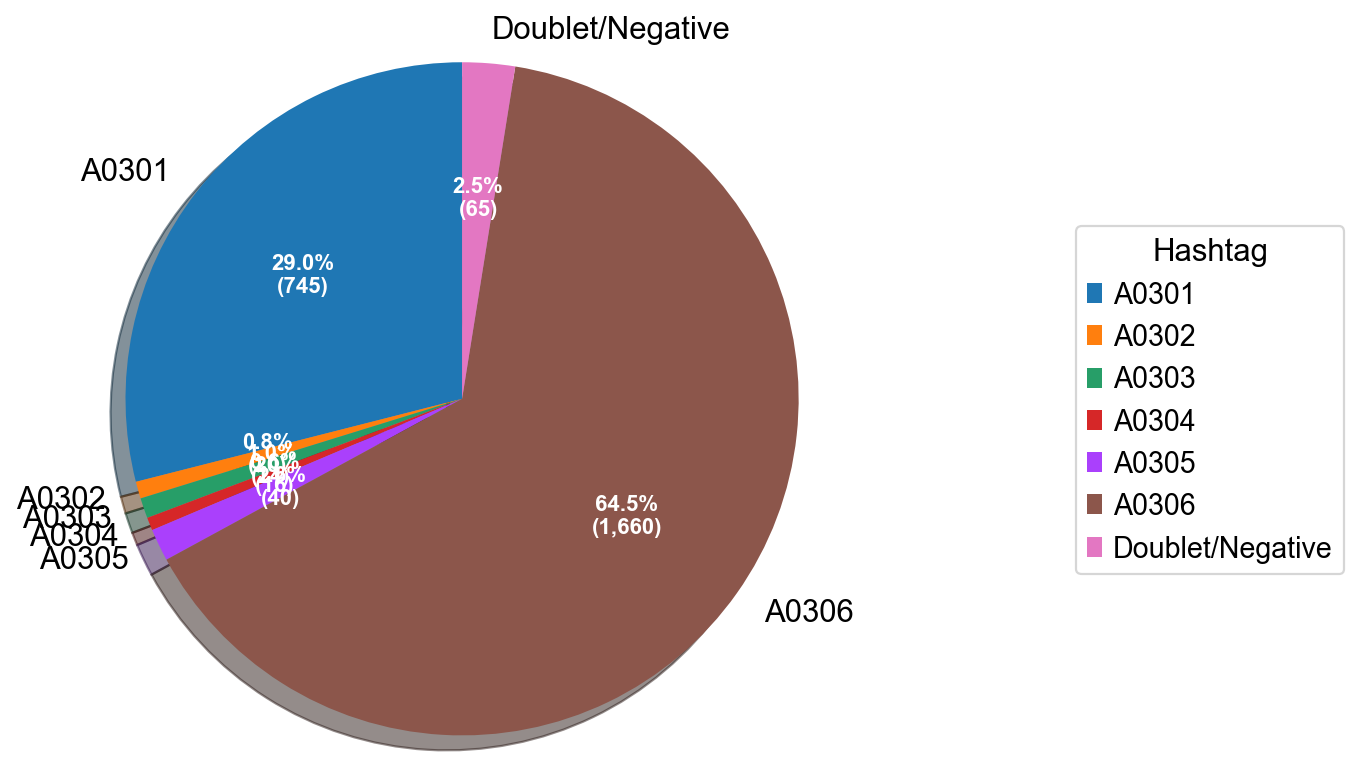

In [41]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

wedges, _, autotexts = ax.pie(
    df_stats,
    labels=labels,
    autopct=lambda pct: func_autopct(pct, df_stats),    
    shadow=True, startangle=90
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    loc="center left",
    bbox_to_anchor=(1.3, 0.0, 0.5, 1)
)

plt.show()

#### Pie 2

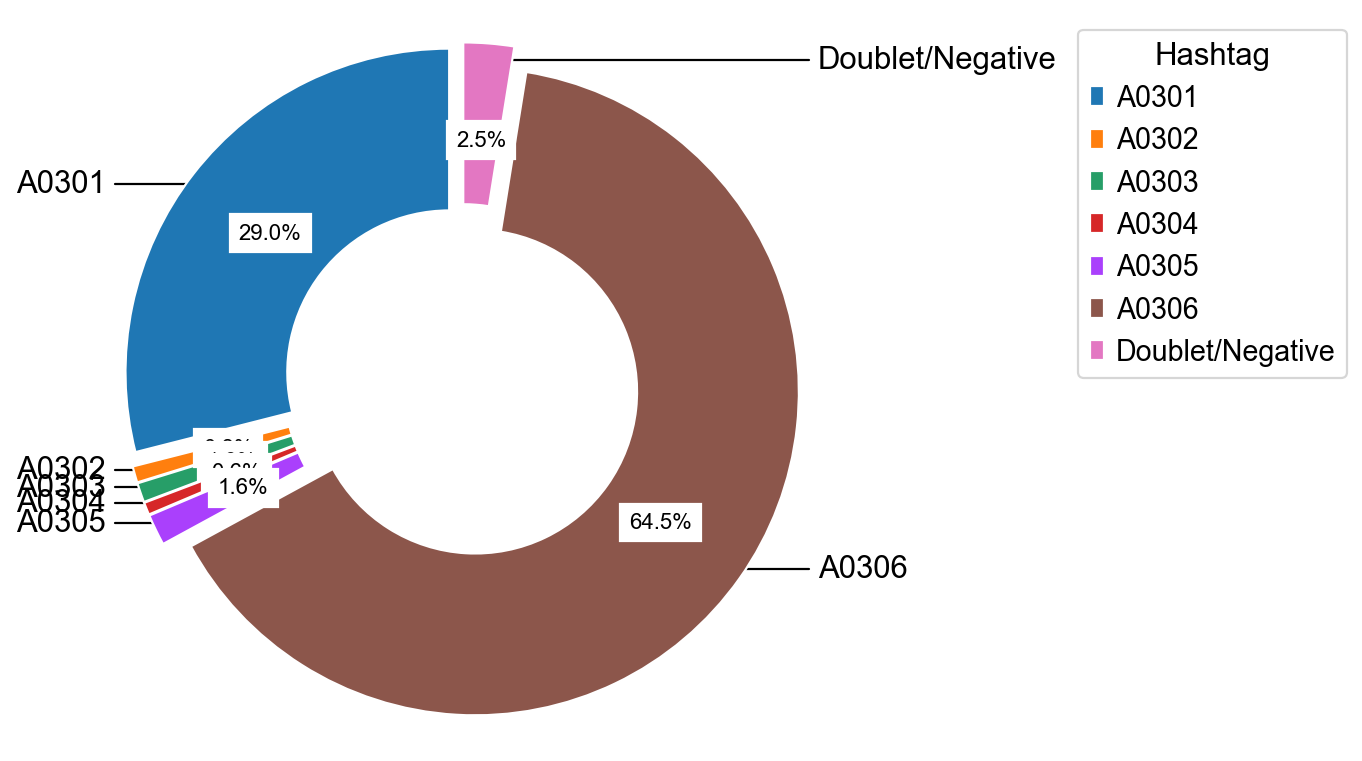

In [42]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

cmap = plt.get_cmap("tab20c")

wedges, _, autotexts = ax.pie(
    df_stats,
    explode=[0.05] * len(df_stats),
    wedgeprops=dict(width=0.5, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.7,
    shadow=False,
    startangle=90,
    rotatelabels=True
)

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        labels[i], xy=(x, y), xytext=(1.1 * np.sign(x), y),
        horizontalalignment=horizontalalignment, **kw
    )

for i, autotext in enumerate(autotexts):
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_rotation(0)
    autotext.set_backgroundcolor("white")
    
ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    bbox_to_anchor=(1.2, 0.0, 0.5, 1)
)

plt.show()

### Distribution

In [43]:
df_dist = df_stats.drop(labels=["Doublet"])
df_dist

hashID
A0301     745
A0302      21
A0303      25
A0304      16
A0305      40
A0306    1660
dtype: int64

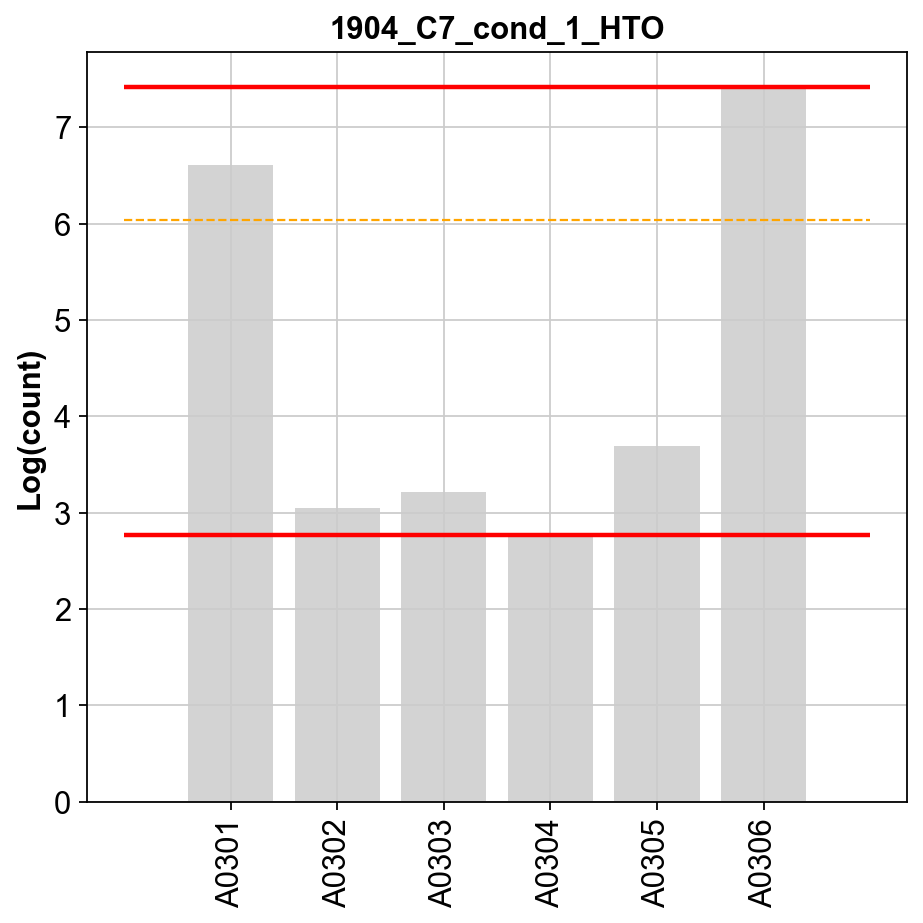

In [44]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.bar(df_dist.index, np.log(list(df_dist.values)), color="lightgray")
    
ax.set_ylabel("Log(count)", fontweight="bold")
ax.set_title(sample_name, fontsize=14, fontweight="heavy")
ax.tick_params(axis="x", rotation=90)
    
if len(df_dist) != 0:
    num_hashtags = len(df_dist.values)
    ax.hlines(y=np.log(max(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
    ax.hlines(y=np.log(min(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)    
    ax.hlines(y=np.log(np.mean(list(df_dist.values))), xmin=-1, xmax=num_hashtags, colors='orange', linestyles='--', lw=1)    

plt.tight_layout()

plt.show()

## Reads Count

In [45]:
adata.to_df(layer="reads")

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
AATTCCTCATAGAATG                  12809                      2   
AACCTTTTCGTAGGGA                     12                     24   
TACACCCGTTTCGCTC                  18114                      0   
ACACTGACACCAGTTA                      1                      0   
AAAGTCCGTGCCTGAC                  19084                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                     16                     89   
CTAGGTACAAGGCGTA                     20                     26   
CTGCGAGTCTGAATCG                     15                     17   
AGGCCACGTAATGCTC                      3                     81   
TCGTGGGAGGCGAAGG                     16                     14   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
AATTCCTCATAGAATG                      3                      2   
AACCTTTTCGTAGGGA                      0                      1   
TACACCCGTTTCGCTC                      5                      0   
ACACTGACACCAGTTA                      0                      0   
AAAGTCCGTGCCTGAC                      1                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                      0                      0   
CTAGGTACAAGGCGTA                      0                     10   
CTGCGAGTCTGAATCG                      0                      0   
AGGCCACGTAATGCTC                      0                      2   
TCGTGGGAGGCGAAGG                      0                      5   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
AATTCCTCATAGAATG                      0                     20  
AACCTTTTCGTAGGGA                      0                  17637  
TACACCCGTTTCGCTC                      0                     16  
ACACTGACACCAGTTA                      0                      0  
AAAGTCCGTGCCTGAC                      3                     61  
...                                 ...                    ...  
GCGAGAATCACCATGA                      0                  19185  
CTAGGTACAAGGCGTA                      2                  15645  
CTGCGAGTCTGAATCG                      0                   8599  
AGGCCACGTAATGCTC                      1                  14048  
TCGTGGGAGGCGAAGG                      0                   7559  

[2572 rows x 6 columns]

### Matrix vs. Run Report

Note that unmapped reads are excluded.

In [46]:
adata.layers["reads"].sum()

42589076

In [47]:
adata.layers["reads"].sum(), run_report["Reads processed"]

(42589076, 56902257)

In [48]:
adata.layers["reads"].sum() / run_report["Reads processed"] * 100

74.84602236427985

### Total Reads per Hashtag

In [49]:
adata.var["total_reads"] = adata.layers["reads"].sum(axis=0).A1

In [50]:
adata.var["total_reads"]

A0301-ACCCACCAGTAAGAC    13815454
A0302-GGTCGAGAGCATTCA      679743
A0303-CTTGCCGCATGTCAT      542529
A0304-AAAGCATTCTTCACG      568818
A0305-CTTTGTCTTTGTGAG      256863
A0306-TATGCTGCCACGGTA    26725669
Name: total_reads, dtype: int64

### Total Reads per Celluar Barcode

In [51]:
adata.obs["total_reads"] = adata.layers["reads"].sum(axis=1).A1

In [52]:
adata.obs["total_reads"]

cell_barcodes
AATTCCTCATAGAATG    12836
AACCTTTTCGTAGGGA    17674
TACACCCGTTTCGCTC    18135
ACACTGACACCAGTTA        1
AAAGTCCGTGCCTGAC    19149
                    ...  
GCGAGAATCACCATGA    19290
CTAGGTACAAGGCGTA    15703
CTGCGAGTCTGAATCG     8631
AGGCCACGTAATGCTC    14135
TCGTGGGAGGCGAAGG     7594
Name: total_reads, Length: 2572, dtype: int64

### Zero Rows

In [53]:
np.count_nonzero(adata.obs["total_reads"] == 0)

20

In [54]:
np.count_nonzero(adata.obs["total_reads"] == 0) / adata.shape[0]

0.007776049766718507

### First Hashtag

In [55]:
# remove "Doublet" and pick the first hashtag
hashtags = list(set(df_class.hashID.unique()) - set(["Doublet"]))
first_hashtag = hashtags[0] if len(hashtags) > 0 else None
first_hashtag

'A0302'

In [56]:
adata.to_df(layer="reads")[adata.obs["hashID"] == first_hashtag].sort_values(adata.var.index[0], ascending=False)

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
TCATGGATCTGGGCGT                    177                  42776   
ATTTCTGCACCAAATC                    141                  38472   
CCCTTAGTCGCAAGAG                    126                  38060   
TATTGGGGTCGACTGC                    114                  23387   
CTGTACCCATTCACCC                    111                  33042   
ACCGTTCAGATACTGA                    109                  27436   
ACTCTCGGTCGTCTCT                    107                  33711   
TTACAGGAGGTTCACT                    107                  35783   
CATACAGCAGTATACC                    103                  32520   
GCTGCAGTCCCGAATA                     98                  23451   
GTATTTCAGACCAACG                     93                  33791   
GCAGCTGTCTCTCGCA                     90                  34875   
TCATGAGAGTAGGATT                     75                  15769   
GTTGCGGTCGACCAAT                     73                  19895   
GGAACCCTCGAACTCA                     72                  31701   
TTTCAGTCATCGAACT                     66                  27150   
GTCTTTAAGAGTCTGG                     65                  27041   
CATCGTCAGACAGTCG                     58                  18784   
GTTCATTGTCAGTCTA                     55                  18745   
CCAATTTTCGAGAGCA                     50                  20327   
CGGACACAGGGCATGT                      0                      3   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
TCATGGATCTGGGCGT                      0                      1   
ATTTCTGCACCAAATC                      0                      0   
CCCTTAGTCGCAAGAG                      5                      0   
TATTGGGGTCGACTGC                      0                      8   
CTGTACCCATTCACCC                      0                      0   
ACCGTTCAGATACTGA                      0                      1   
ACTCTCGGTCGTCTCT                      0                      4   
TTACAGGAGGTTCACT                      2                      4   
CATACAGCAGTATACC                      0                      5   
GCTGCAGTCCCGAATA                      0                      0   
GTATTTCAGACCAACG                      0                      5   
GCAGCTGTCTCTCGCA                      0                      6   
TCATGAGAGTAGGATT                      0                      1   
GTTGCGGTCGACCAAT                      0                      0   
GGAACCCTCGAACTCA                      0                      0   
TTTCAGTCATCGAACT                      0                      5   
GTCTTTAAGAGTCTGG                      2                      0   
CATCGTCAGACAGTCG                      4                      2   
GTTCATTGTCAGTCTA                      0                      0   
CCAATTTTCGAGAGCA                      4                      0   
CGGACACAGGGCATGT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
TCATGGATCTGGGCGT                      1                     50  
ATTTCTGCACCAAATC                      0                     31  
CCCTTAGTCGCAAGAG                      0                     60  
TATTGGGGTCGACTGC                      0                     16  
CTGTACCCATTCACCC                      0                     34  
ACCGTTCAGATACTGA                      0                     19  
ACTCTCGGTCGTCTCT                     11                     32  
TTACAGGAGGTTCACT                      0                     64  
CATACAGCAGTATACC                      1                     47  
GCTGCAGTCCCGAATA                      6                     20  
GTATTTCAGACCAACG                      0                     32  
GCAGCTGTCTCTCGCA                      0                     33  
TCATGAGAGTAGGATT                      3                     21  
GTTGC

### Overall Stats

In [57]:
adata.to_df(layer="reads").sum(axis=1).describe()

count     2572.000000
mean     16558.738725
std       7086.609228
min          0.000000
25%      13209.750000
50%      15783.500000
75%      19074.250000
max      54183.000000
dtype: float64

### 95 Percentile

In [58]:
percentile_95 = adata.obs["total_reads"].describe(percentiles=[0.95])["95%"]
percentile_95

30599.6

In [59]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ]

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
TCTACATCAACTACGT                  19621                     77   
ATAGGCTGTCTCCTGT                      5                     80   
GACCAATTCCATCACC                  37441                      0   
GAACTGTGTTCTTGCC                     34                     62   
TATATCCGTCATCTAG                  32648                      2   
...                                 ...                    ...   
TAGGAGGCACATAGCT                  39839                      0   
TCGGTCTAGGAGAGGC                     15                     69   
AACGGGACATAGATCC                  31819                      0   
GAGTTACCAGCAGGAT                     29                     72   
CTGTACCCATTCACCC                    111                  33042   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
TCTACATCAACTACGT                     11                      0   
ATAGGCTGTCTCCTGT                      0                      2   
GACCAATTCCATCACC                     11                      1   
GAACTGTGTTCTTGCC                      1                      0   
TATATCCGTCATCTAG                      0                      0   
...                                 ...                    ...   
TAGGAGGCACATAGCT                      8                      0   
TCGGTCTAGGAGAGGC                      0                      0   
AACGGGACATAGATCC                     10                      0   
GAGTTACCAGCAGGAT                      0                      0   
CTGTACCCATTCACCC                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
TCTACATCAACTACGT                      0                  16877  
ATAGGCTGTCTCCTGT                      2                  30689  
GACCAATTCCATCACC                      0                     36  
GAACTGTGTTCTTGCC                      0                  30516  
TATATCCGTCATCTAG                      2                     38  
...                                 ...                    ...  
TAGGAGGCACATAGCT                      0                     40  
TCGGTCTAGGAGAGGC                      0                  30649  
AACGGGACATAGATCC                      0                     38  
GAGTTACCAGCAGGAT                      1                  39176  
CTGTACCCATTCACCC                      0                     34  

[129 rows x 6 columns]

In [60]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ].sample(5, random_state=0)

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CCTTCAGCATCGCTGG                    586                     63   
CCCAACTCAATACCTG                     27                     78   
ATTCAGGTCTCATAGG                  14234                     54   
TTACAGGAGGTTCACT                    107                  35783   
GTATTTCAGACCAACG                     93                  33791   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CCTTCAGCATCGCTGG                      0                      1   
CCCAACTCAATACCTG                      0                      0   
ATTCAGGTCTCATAGG                      3                      0   
TTACAGGAGGTTCACT                      2                      4   
GTATTTCAGACCAACG                      0                      5   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CCTTCAGCATCGCTGG                     10                  39086  
CCCAACTCAATACCTG                      1                  42624  
ATTCAGGTCTCATAGG                      0                  17928  
TTACAGGAGGTTCACT                      0                     64  
GTATTTCAGACCAACG                      0                     32

In [61]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ].sample(5, random_state=0).sum(axis=1)

cell_barcodes
CCTTCAGCATCGCTGG    39746
CCCAACTCAATACCTG    42730
ATTCAGGTCTCATAGG    32219
TTACAGGAGGTTCACT    35960
GTATTTCAGACCAACG    33921
dtype: int64

### Histogram (sum of reads across hashtags)

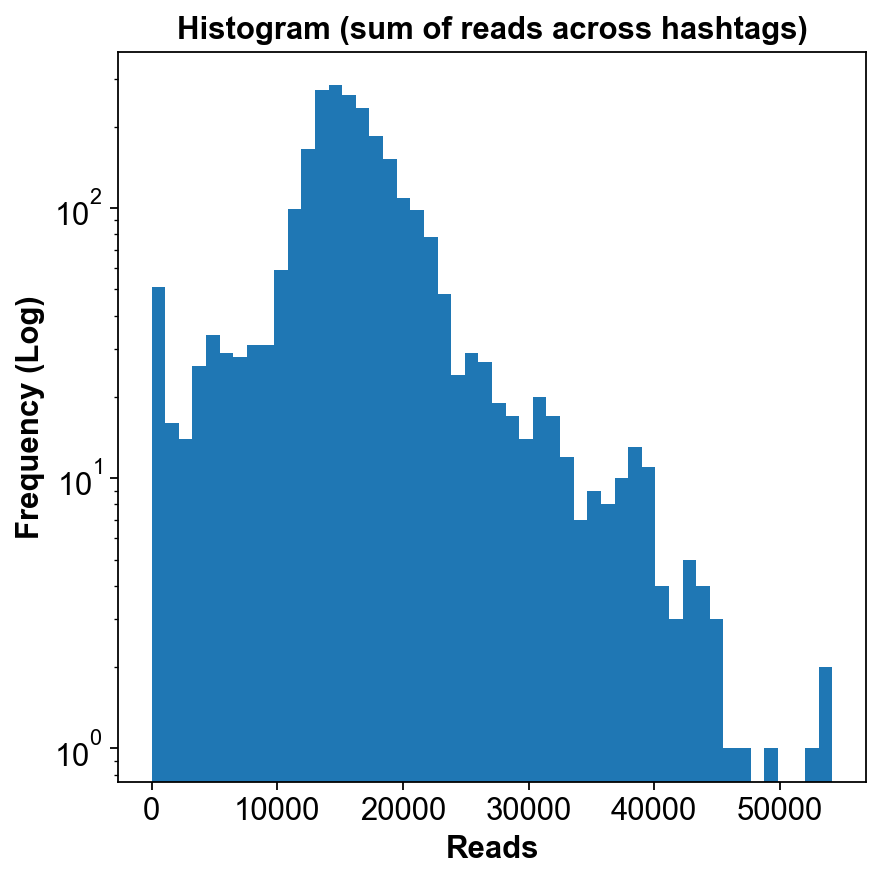

In [62]:
fig, ax = plt.subplots(figsize=(6,6), facecolor="white")

ax.hist(adata.obs["total_reads"].sort_values(ascending=False), bins=50)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.set_title("Histogram (sum of reads across hashtags)", fontweight="bold")
ax.grid(b=False)

plt.yscale("log")
plt.show()

### Histogram (sum of reads per hashtag)

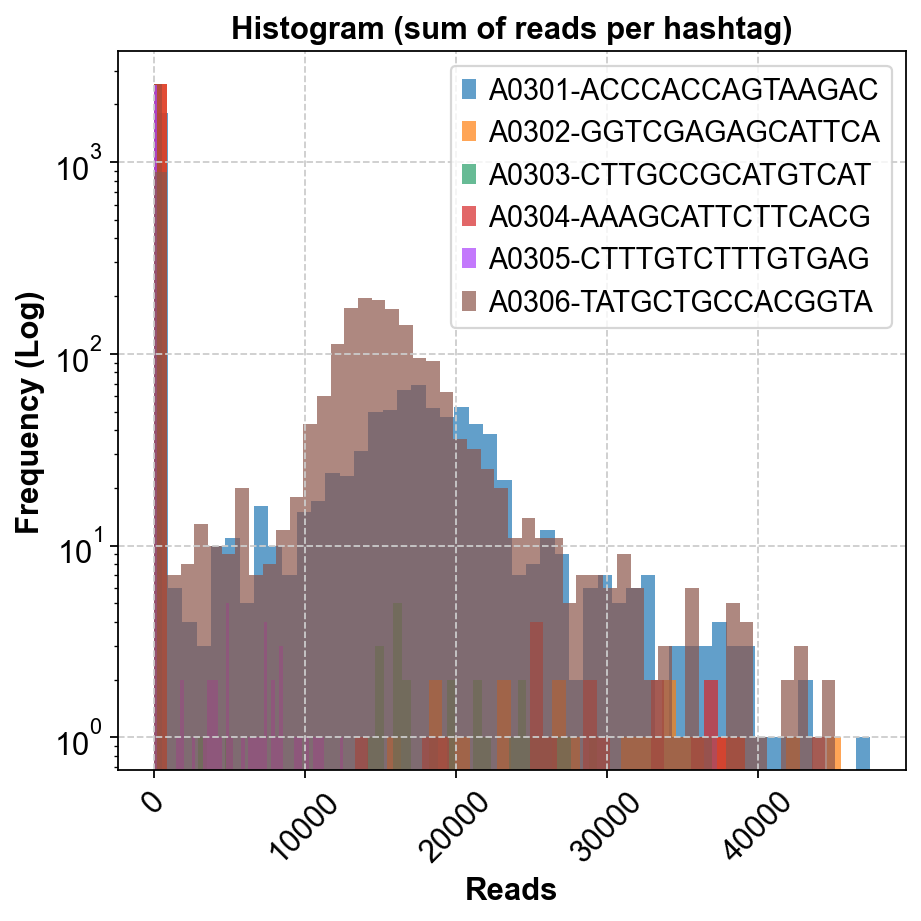

In [63]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
    
for idx, col in enumerate(adata.var_names):
    
    df_tmp = np.sort(adata.layers["reads"][:, idx].A.ravel())[::-1]

    ax.hist(df_tmp, bins=50, alpha=0.7, label=col)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Histogram (sum of reads per hashtag)", fontweight="bold")
ax.grid(b=True, linestyle="--")
ax.legend()

plt.yscale("log")
plt.tight_layout()
plt.show()

### Unmapped

In [64]:
adata.obs["unmapped_reads"].sort_values(ascending=False)

cell_barcodes
CGGAATTAGGAACGAA    1191
TTGAACGTCAGCCTCT    1101
GATGATCCACTTCAAG    1055
GGCAGTCTCTTCGGTC    1044
GAGTTACCAGCAGGAT    1022
                    ... 
AGTCAACAGCAGTTCC       0
GTATTGGAGGTTCTGC       0
CATCCACCACCTCGTT       0
CTACATTCAGGGATTG       0
TTAGGCAGTTCTCATT       0
Name: unmapped_reads, Length: 2572, dtype: int64

In [65]:
adata.obs["unmapped_reads"].sum()

911838

## UMI Count

In [66]:
adata.to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
AATTCCTCATAGAATG                   4506                      1   
AACCTTTTCGTAGGGA                      8                      7   
TACACCCGTTTCGCTC                   6297                      0   
ACACTGACACCAGTTA                      1                      0   
AAAGTCCGTGCCTGAC                   6539                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                      7                     17   
CTAGGTACAAGGCGTA                     11                      8   
CTGCGAGTCTGAATCG                      7                      5   
AGGCCACGTAATGCTC                      3                     15   
TCGTGGGAGGCGAAGG                      7                      3   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
AATTCCTCATAGAATG                      2                      1   
AACCTTTTCGTAGGGA                      0                      1   
TACACCCGTTTCGCTC                      1                      0   
ACACTGACACCAGTTA                      0                      0   
AAAGTCCGTGCCTGAC                      1                      0   
...                                 ...                    ...   
GCGAGAATCACCATGA                      0                      0   
CTAGGTACAAGGCGTA                      0                      4   
CTGCGAGTCTGAATCG                      0                      0   
AGGCCACGTAATGCTC                      0                      1   
TCGTGGGAGGCGAAGG                      0                      2   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
AATTCCTCATAGAATG                      0                      8  
AACCTTTTCGTAGGGA                      0                   6255  
TACACCCGTTTCGCTC                      0                      8  
ACACTGACACCAGTTA                      0                      0  
AAAGTCCGTGCCTGAC                      1                     25  
...                                 ...                    ...  
GCGAGAATCACCATGA                      0                   6611  
CTAGGTACAAGGCGTA                      1                   5513  
CTGCGAGTCTGAATCG                      0                   3022  
AGGCCACGTAATGCTC                      1                   4664  
TCGTGGGAGGCGAAGG                      0                   3238  

[2572 rows x 6 columns]

In [67]:
# total UMIs per cell barcode
adata.obs["total_umis"] = adata.X.sum(axis=1).A1

### Histogram (sum of UMIs across hashtag)

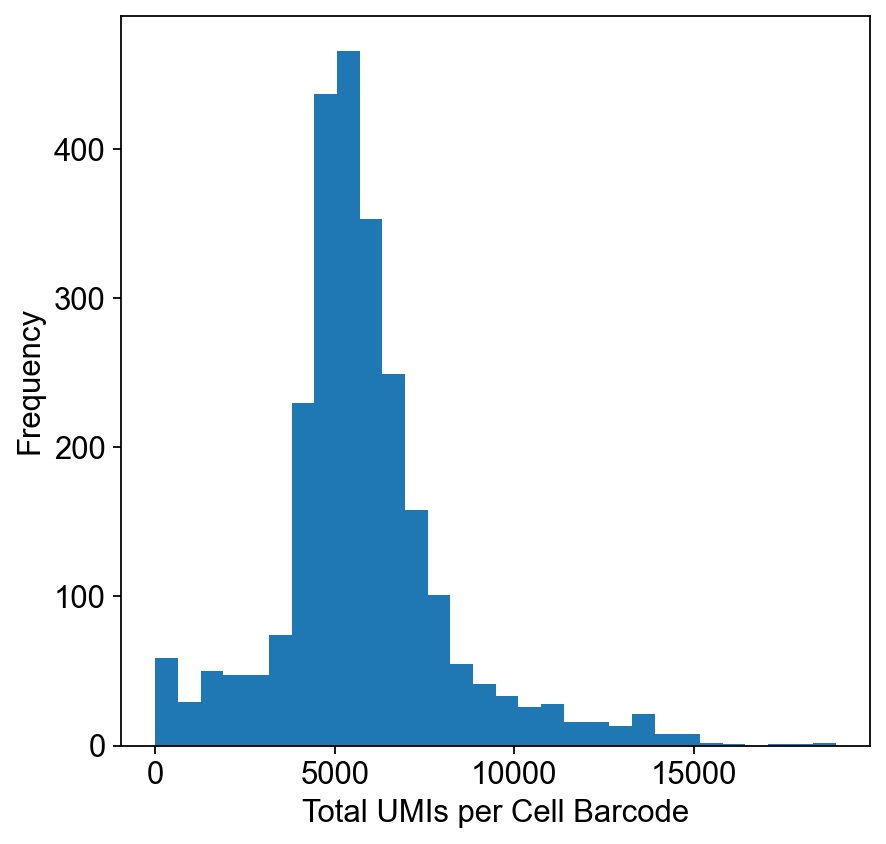

In [68]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

ax.hist(adata.obs["total_umis"], bins=30)
ax.set_xlabel("Total UMIs per Cell Barcode")
ax.set_ylabel("Frequency")
ax.grid(b=False)

plt.tight_layout
plt.show()

In [69]:
adata.to_df().describe()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  A0303-CTTGCCGCATGTCAT  \
count            2572.000000            2572.000000            2572.000000   
mean             1883.757776              88.072317              73.449456   
std              3154.480596             944.928521             727.669948   
min                 0.000000               0.000000               0.000000   
25%                 7.000000               1.000000               0.000000   
50%                10.000000               5.000000               0.000000   
75%              4329.750000               9.000000               1.000000   
max             15805.000000           15437.000000            9990.000000   

       A0304-AAAGCATTCTTCACG  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
count            2572.000000             2572.00000            2572.000000  
mean               73.921462               33.36042            3596.866641  
std               875.401923              287.67102            3016.762474  
min                 0.000000                0.00000               0.000000  
25%                 0.000000                0.00000              14.000000  
50%                 0.000000                0.00000            4524.000000  
75%                 1.000000                0.00000            5555.750000  
max             14085.000000             4245.00000           15218.000000

## Reads per UMI

### Calculate

In [70]:
# reads divided by UMI, replace NaN with zero
reads_per_umi = np.nan_to_num(adata.layers["reads"] / adata.X)

In [71]:
pd.DataFrame(reads_per_umi)

0         1    2    3    4         5
0     2.842654  2.000000  1.5  2.0  0.0  2.500000
1     1.500000  3.428571  0.0  1.0  0.0  2.819664
2     2.876608  0.000000  5.0  0.0  0.0  2.000000
3     1.000000  0.000000  0.0  0.0  0.0  0.000000
4     2.918489  0.000000  1.0  0.0  3.0  2.440000
...        ...       ...  ...  ...  ...       ...
2567  2.285714  5.235294  0.0  0.0  0.0  2.901982
2568  1.818182  3.250000  0.0  2.5  2.0  2.837838
2569  2.142857  3.400000  0.0  0.0  0.0  2.845467
2570  1.000000  5.400000  0.0  2.0  1.0  3.012007
2571  2.285714  4.666667  0.0  2.5  0.0  2.334466

[2572 rows x 6 columns]

In [72]:
adata.obs["total_umis"].sum()

14787529

In [73]:
adata.obs["total_reads"].sum()

42589076

In [74]:
avg_reads_per_umi= adata.obs["total_reads"].sum() / adata.obs["total_umis"].sum()
avg_reads_per_umi

2.880067116013771

### Histogram

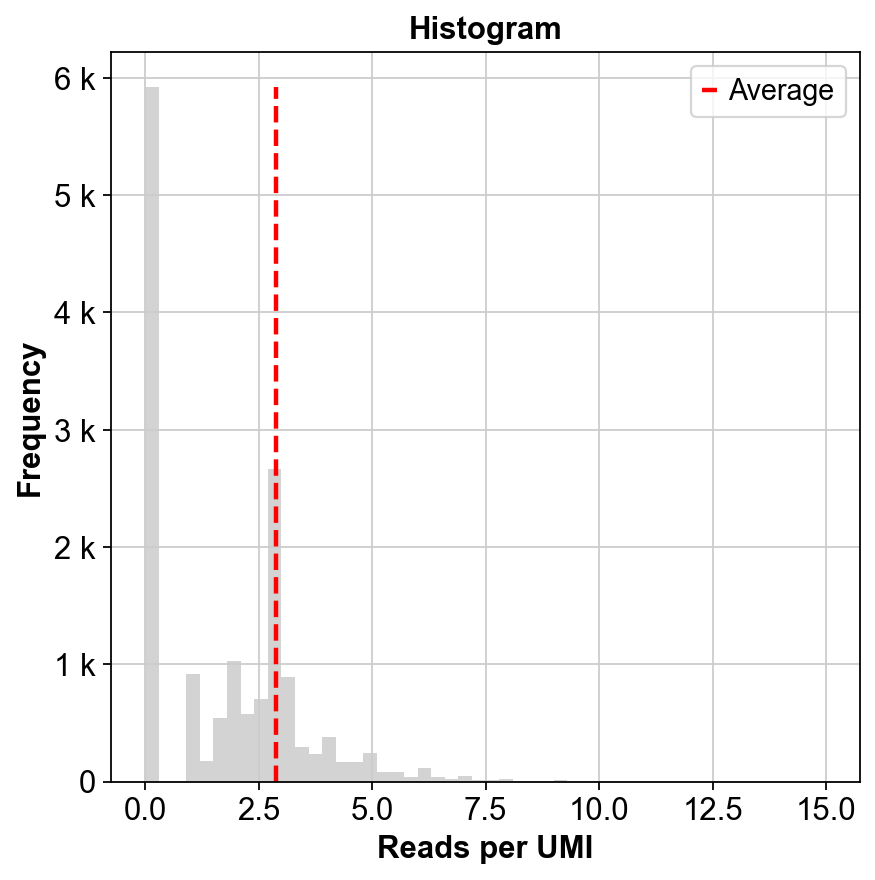

In [75]:
fig, ax = plt.subplots(figsize=(6,6), facecolor="white")

n, bins, _ = ax.hist(reads_per_umi.A1, bins=50, color="lightgray")
ax.vlines(x=avg_reads_per_umi, ymin=0, ymax=np.max(n), color="red", linestyle="--", lw=2, label="Average")

ax.set_xlabel("Reads per UMI", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.set_title("Histogram", fontweight="bold")
ax.legend()

plt.show()

## UMI (one vs. rest)

- Ideally, the winning one shouldn't be winning by having less than e.g. 10 UMIs?
- Ideally, the losing ones should have UMIs close to zero.

### All

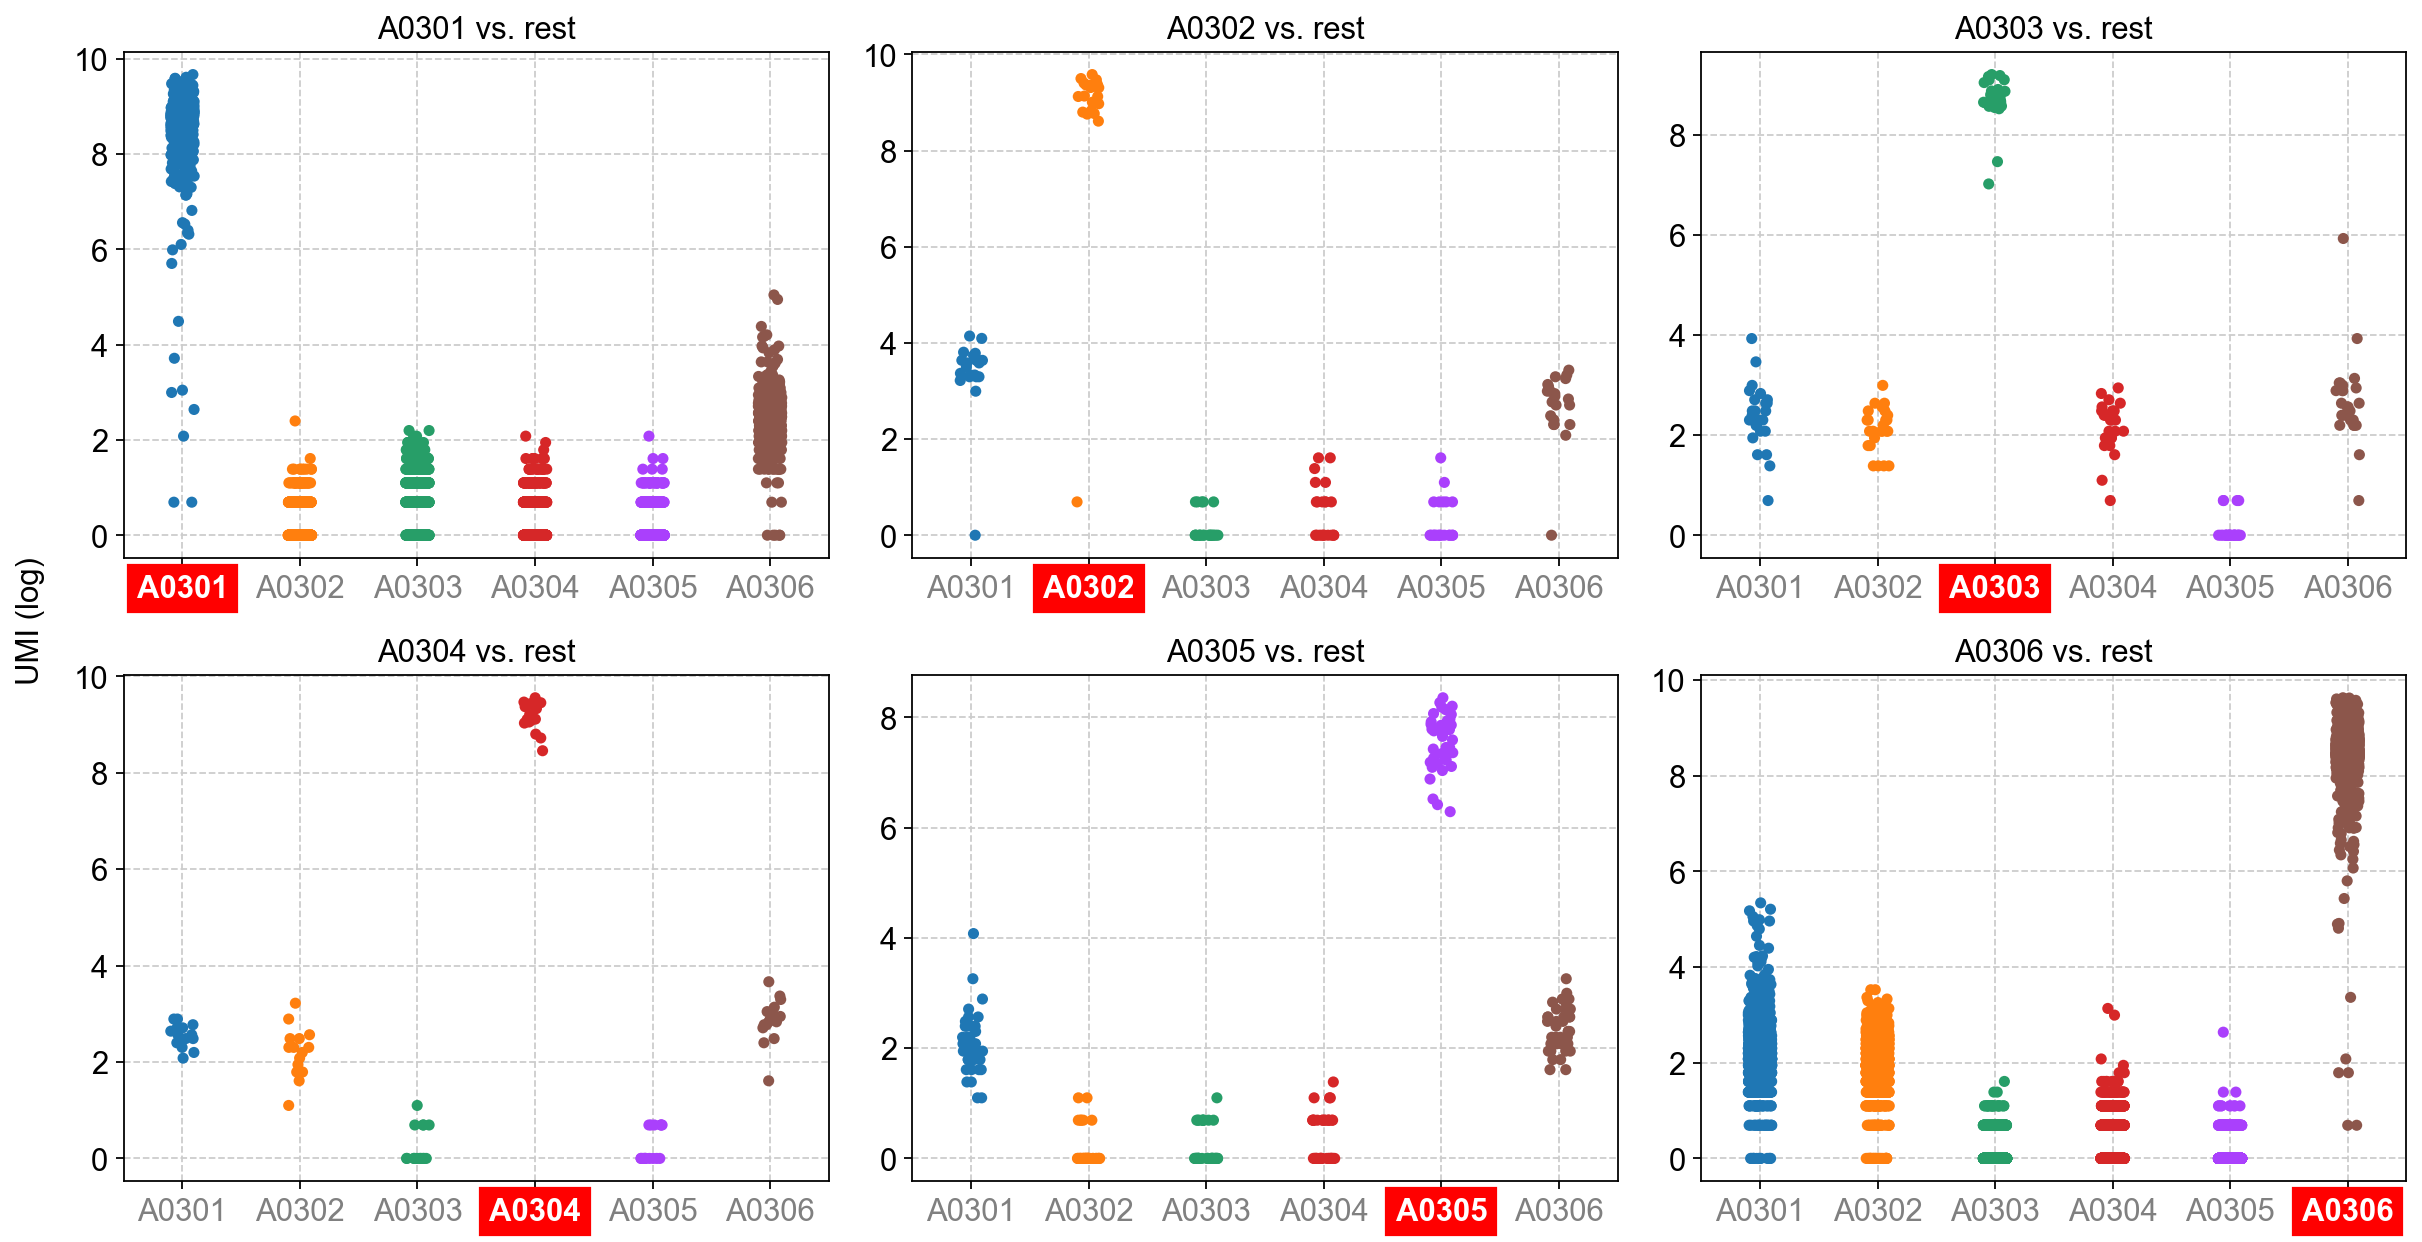

In [76]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = math.ceil(num_hashtags / num_cols)

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, num_rows * 4), facecolor="white")
axes = np.ravel(axes)

for idx, hashtag in enumerate(sorted(hashtags)):

    ax = axes[idx]

    df_tmp = adata[adata.obs["hashID"] == hashtag].to_df()
    df_tmp.columns = df_tmp.columns.str.split("-").str[0]

    sns.stripplot(data=np.log1p(df_tmp), ax=ax)

    ax.set_title(f"{hashtag} vs. rest")
    ax.grid(b=True, linestyle="--")

    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("white")
            tick.label.set_fontweight("heavy")
            tick.label.set_backgroundcolor("red")
        else:
            tick.label.set_color("gray")

fig.text(-0.01, 0.5, "UMI (log)", va='center', rotation='vertical')
plt.tight_layout()
plt.show()

### 25th Percentile

In [77]:
umi_sum_percentile_25 = adata.obs["total_umis"].describe()["25%"]
umi_sum_percentile_25

4596.0

In [78]:
adata[ (adata.obs["total_umis"] < umi_sum_percentile_25) & (adata.obs["hashID"] != "Doublet") ].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
AATTCCTCATAGAATG                   4506                      1   
ACACTGACACCAGTTA                      1                      0   
TTACCATTCCCGTAAA                      4                      2   
GGGACAAAGTAACGTA                     22                     10   
TGCGATACAAACTAAG                      5                      2   
...                                 ...                    ...   
AGTCACAGTGAGGAAA                      8                      7   
TTTCAGTGTAGCGTAG                      9                      2   
AGGATAATCTACTATC                   4227                      0   
CTGCGAGTCTGAATCG                      7                      5   
TCGTGGGAGGCGAAGG                      7                      3   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
AATTCCTCATAGAATG                      2                      1   
ACACTGACACCAGTTA                      0                      0   
TTACCATTCCCGTAAA                      0                      0   
GGGACAAAGTAACGTA                      1                      1   
TGCGATACAAACTAAG                      0                      0   
...                                 ...                    ...   
AGTCACAGTGAGGAAA                      0                      1   
TTTCAGTGTAGCGTAG                      0                      0   
AGGATAATCTACTATC                      1                      0   
CTGCGAGTCTGAATCG                      0                      0   
TCGTGGGAGGCGAAGG                      0                      2   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
AATTCCTCATAGAATG                      0                      8  
ACACTGACACCAGTTA                      0                      0  
TTACCATTCCCGTAAA                      0                   1009  
GGGACAAAGTAACGTA                      0                   4023  
TGCGATACAAACTAAG                      0                   3865  
...                                 ...                    ...  
AGTCACAGTGAGGAAA                      0                   4286  
TTTCAGTGTAGCGTAG                      0                   3192  
AGGATAATCTACTATC                      0                      5  
CTGCGAGTCTGAATCG                      0                   3022  
TCGTGGGAGGCGAAGG                      0                   3238  

[614 rows x 6 columns]

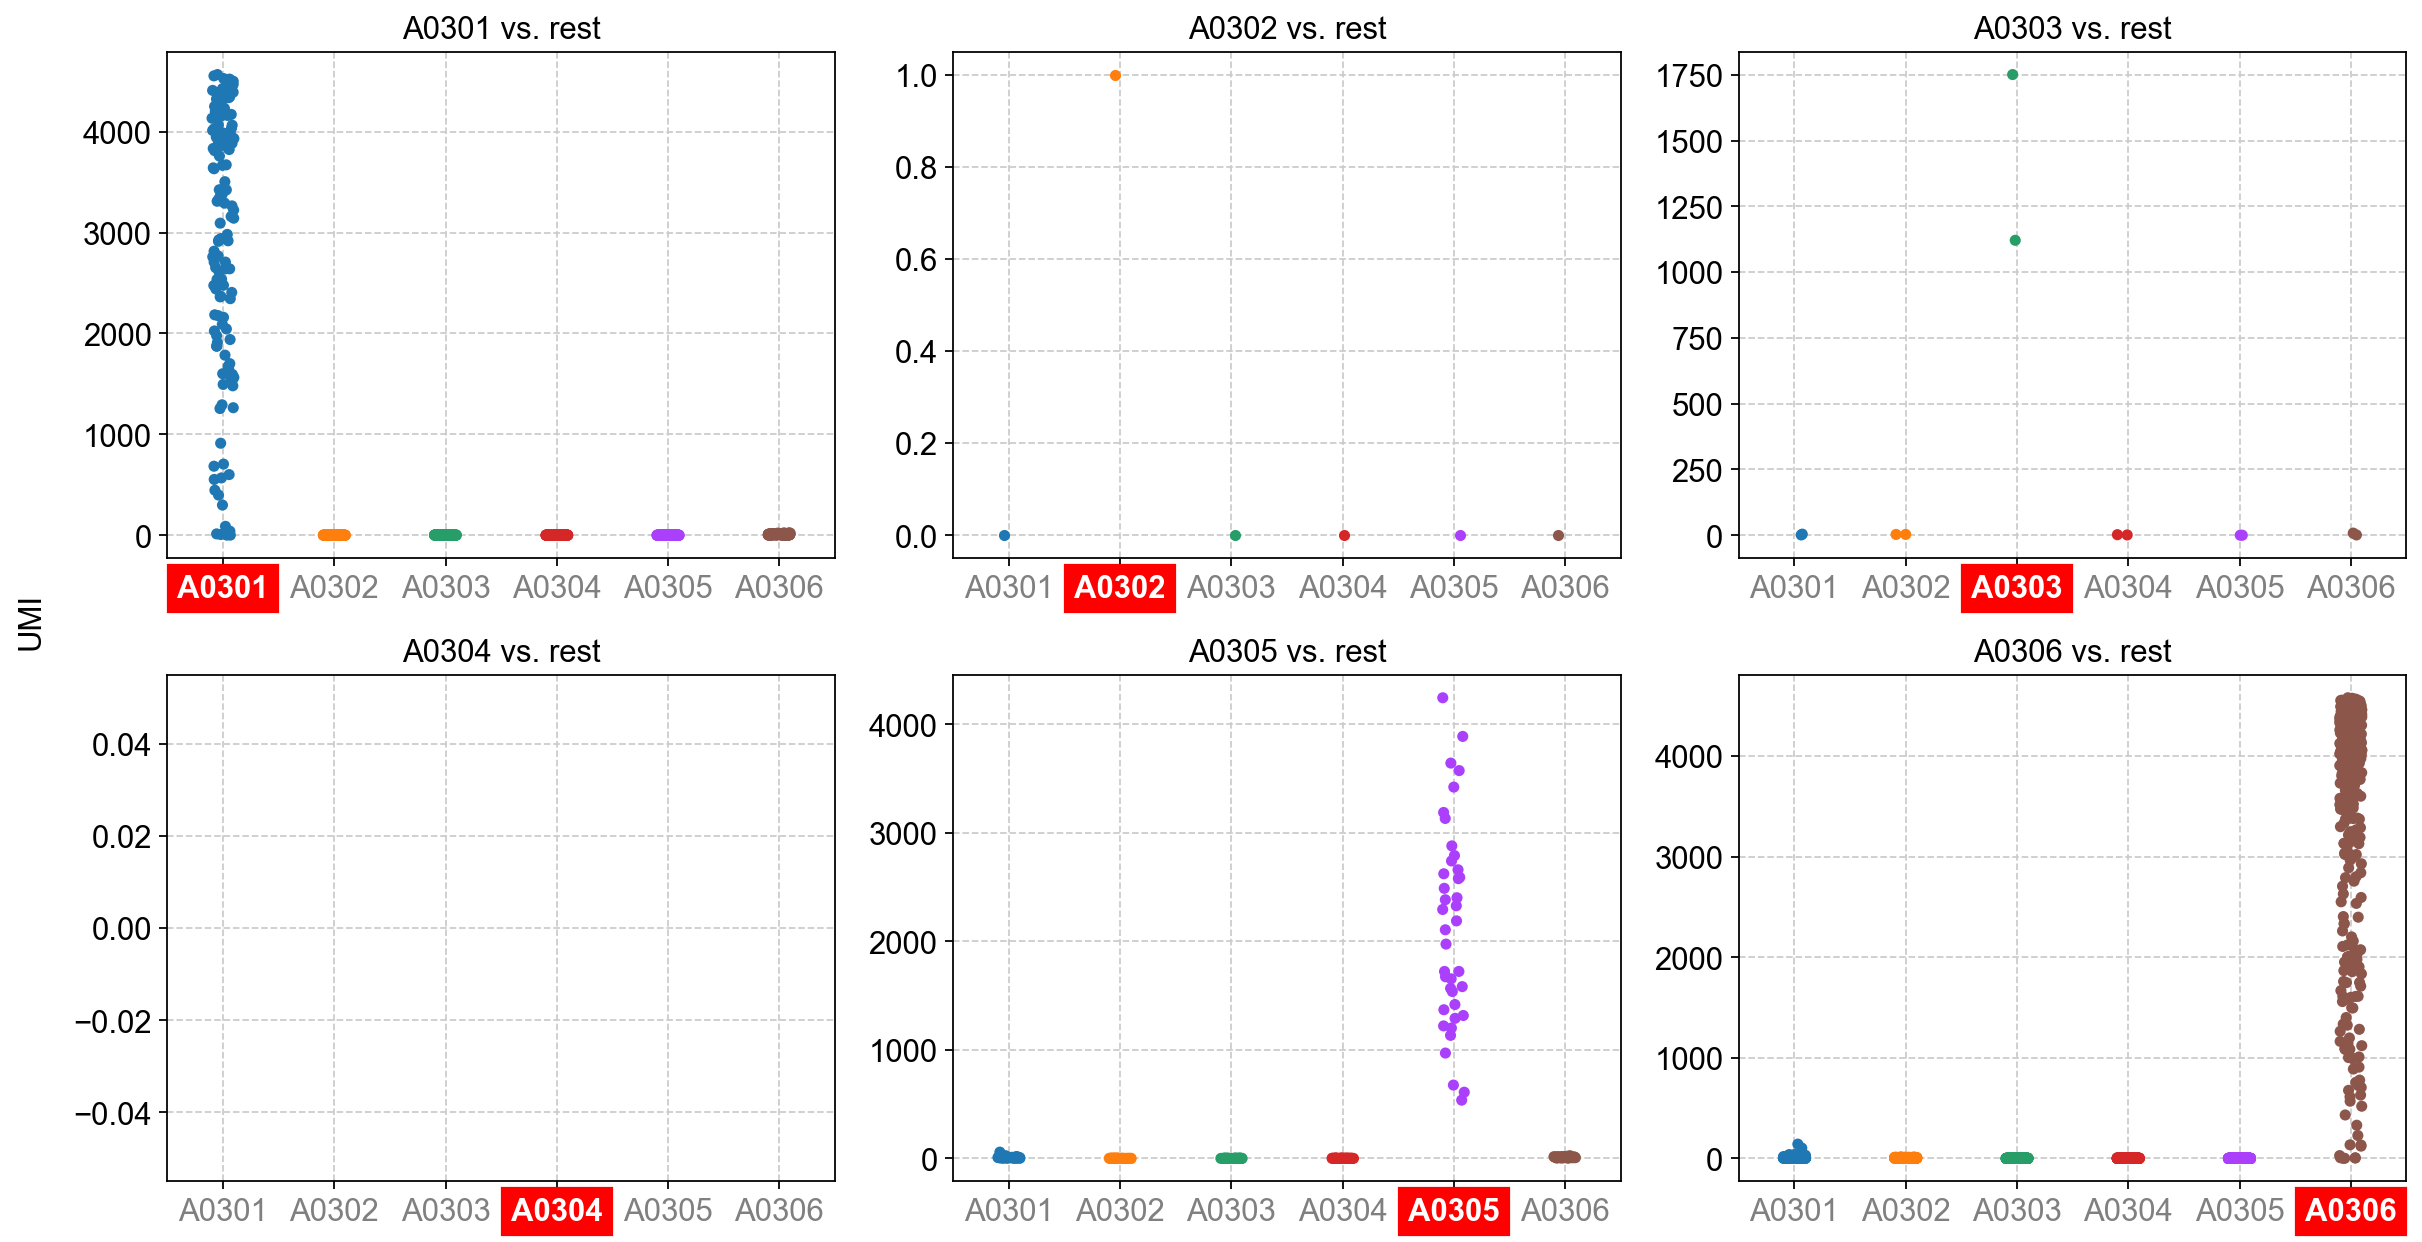

In [79]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = math.ceil(num_hashtags / num_cols)

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, num_rows * 4), facecolor="white")
axes = np.ravel(axes)

for idx, hashtag in enumerate(sorted(hashtags)):

    ax = axes[idx]

    df_tmp = adata[ (adata.obs["total_umis"] < umi_sum_percentile_25) & (adata.obs["hashID"] == hashtag) ].to_df()
    df_tmp.columns = df_tmp.columns.str.split("-").str[0]

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"{hashtag} vs. rest")
    ax.grid(b=True, linestyle="--")

    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("white")
            tick.label.set_fontweight("heavy")
            tick.label.set_backgroundcolor("red")
        else:
            tick.label.set_color("gray")

fig.text(-0.01, 0.5, "UMI", va='center', rotation='vertical')
plt.tight_layout()
plt.show()

## UMI Distribution

/Users/chunj/opt/miniconda3/envs/sharp/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


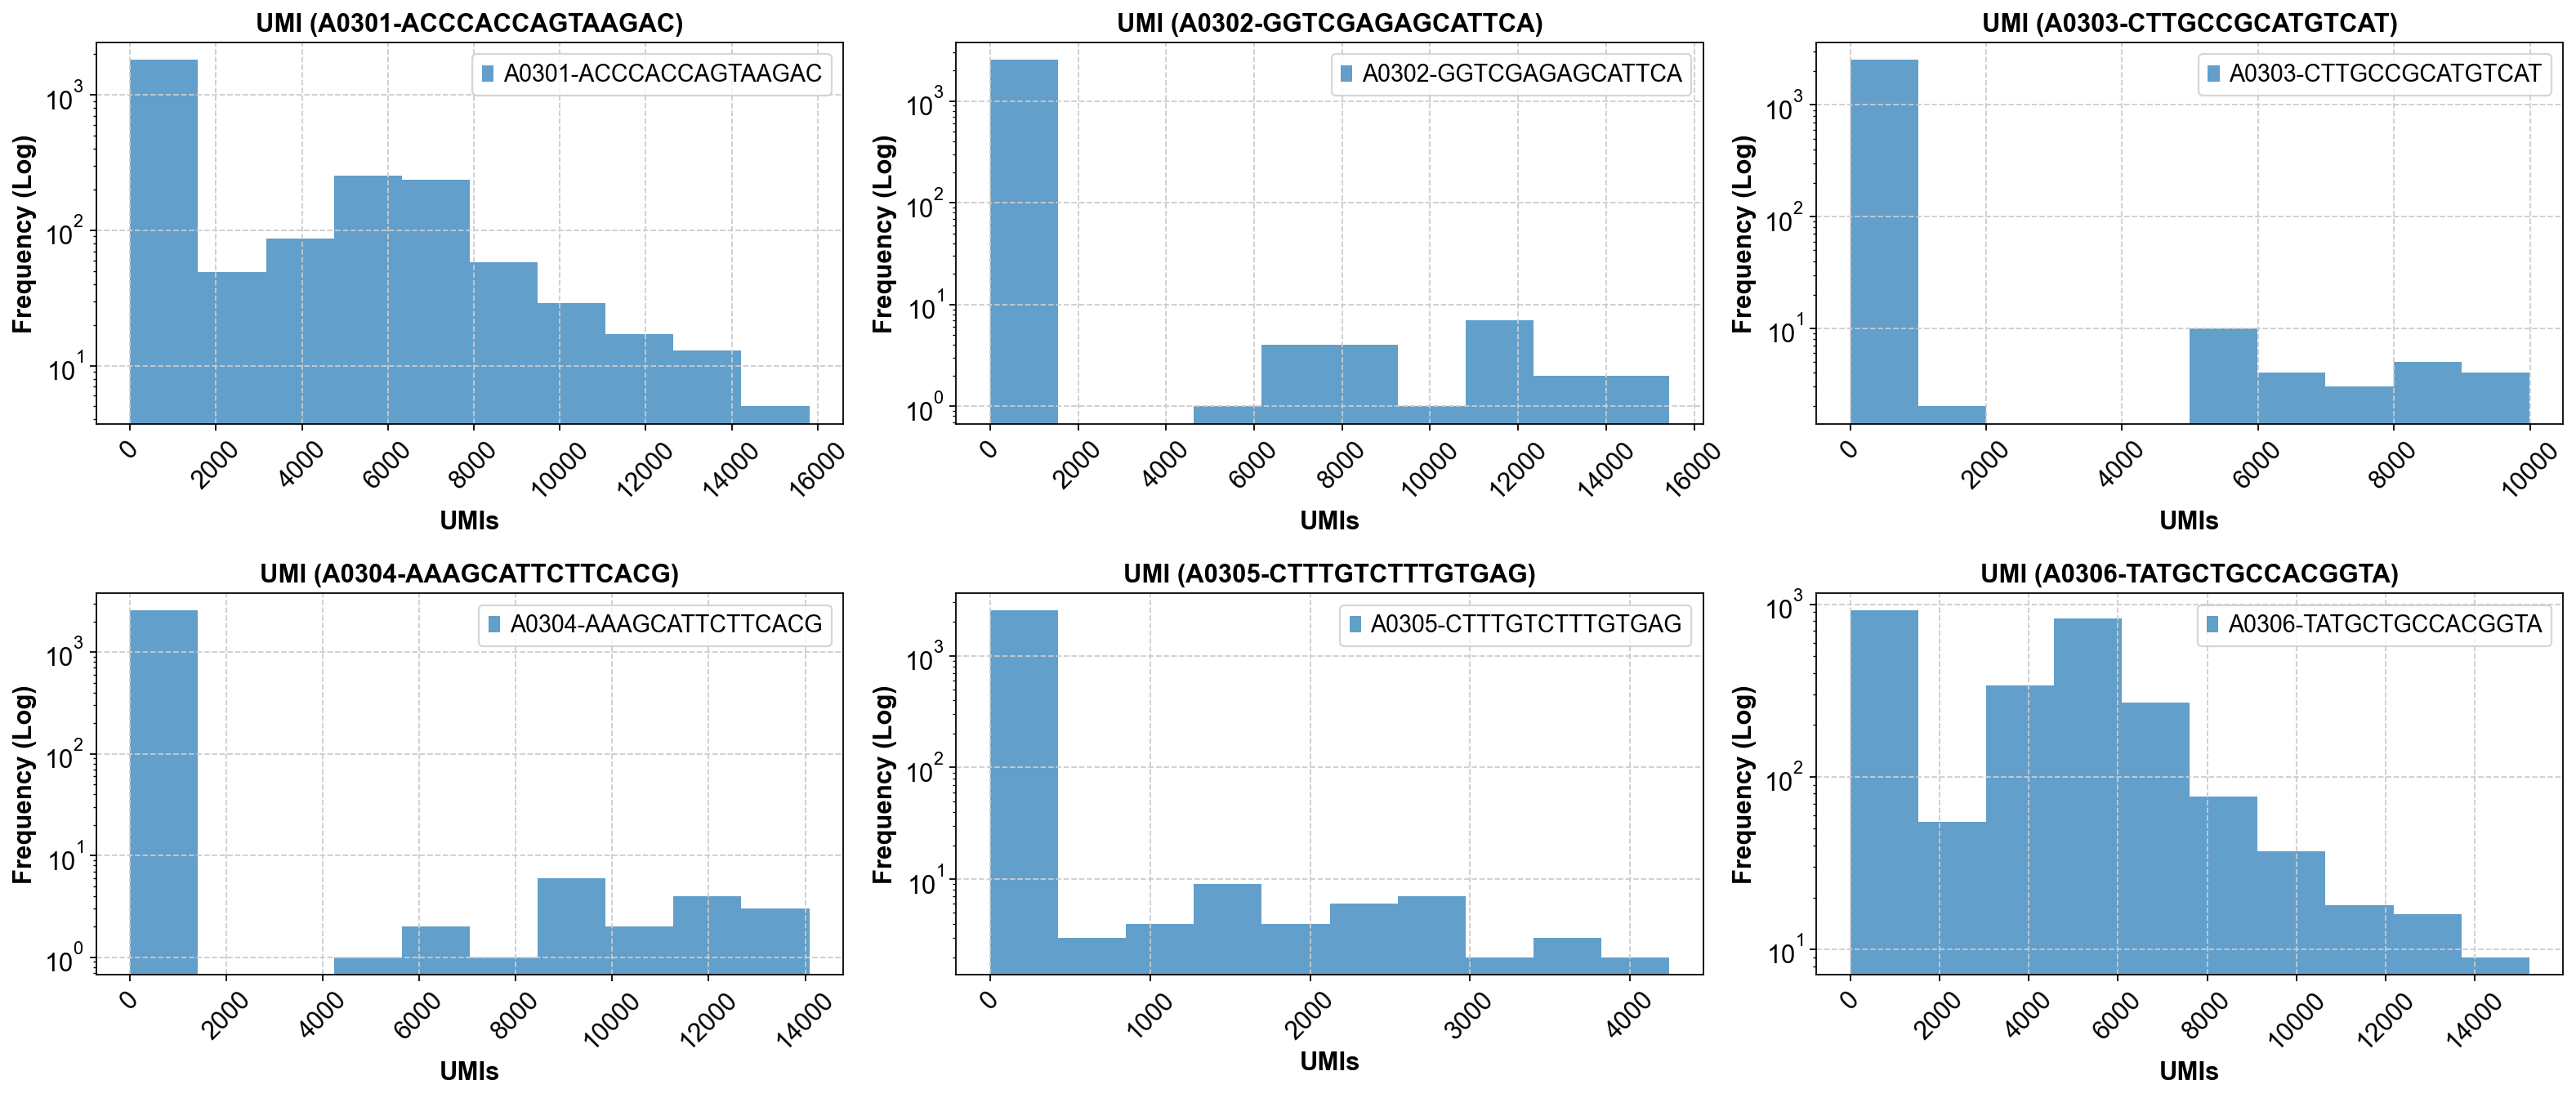

In [80]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for idx, col in enumerate(adata.var_names):

    idx_plot += 1
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)
    
    df_tmp = adata[:, idx].to_df().sort_values(by=adata.var_names[idx], ascending=False)

    ax.hist(df_tmp, bins=10, alpha=0.7, label=col)

    ax.set_xlabel("UMIs", fontweight="bold")
    ax.set_ylabel("Frequency (Log)", fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    ax.set_title(f"UMI ({col})", fontweight="bold")
    ax.grid(b=True, linestyle="--")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

## Negative Check

In [81]:
# sort by total umi in descending order
adata_sorted = adata[adata.obs.sort_values(by="total_umis", ascending=False).index]

In [82]:
adata_sorted.to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                   7370                     12   
GACTCTCGTGCACAAG                   2944                  15437   
TTCCTAAGTAGGCAGT                   9366                     11   
TTGAACGTCAGCCTCT                   5350                     24   
ATCCATTGTCGAACAG                  15805                      0   
...                                 ...                    ...   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                      3                  11565   
GACTCTCGTGCACAAG                      2                      1   
TTCCTAAGTAGGCAGT                   8739                      8   
TTGAACGTCAGCCTCT                      1                      1   
ATCCATTGTCGAACAG                      6                      1   
...                                 ...                    ...   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CGTGAATTCGGTAGAG                      0                     20  
GACTCTCGTGCACAAG                      0                    157  
TTCCTAAGTAGGCAGT                      0                     17  
TTGAACGTCAGCCTCT                      0                  12251  
ATCCATTGTCGAACAG                      1                     19  
...                                 ...                    ...  
TTGCGTCGTAATTGGA                      0                      0  
ACGATGTCACGGCGTT                      0                      0  
TGTCCCAGTGGGTATG                      0                      0  
TAGACCAGTACGAAAT                      0                      0  
CGTCCATAGCCTTGAT                      0                      0  

[2572 rows x 6 columns]

### Zero Rows

In [83]:
adata_sorted[ adata_sorted.obs["total_umis"] == 0 ].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CATCCACCACCTCGTT                      0                      0   
ATAGACCTCGGTGTTA                      0                      0   
CCGGTAGTCACGACTA                      0                      0   
TGGGCGTGTGAGTGAC                      0                      0   
GGGAGATCAGTTTACG                      0                      0   
CGAGGAAGTGGACCTC                      0                      0   
TGTTCCGGTAAGTGTA                      0                      0   
TCACAAGTCAACTCTT                      0                      0   
GTCGTAATCTGGCCTC                      0                      0   
ATTCTACGTGAGCGAT                      0                      0   
CTACATTCAGGGATTG                      0                      0   
ATGCGATCATGAAGTA                      0                      0   
TTAGGCAGTTCTCATT                      0                      0   
TTGCGTCTCCGTAGTA                      0                      0   
TTTATGCCATCCTTGC                      0                      0   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CATCCACCACCTCGTT                      0                      0   
ATAGACCTCGGTGTTA                      0                      0   
CCGGTAGTCACGACTA                      0                      0   
TGGGCGTGTGAGTGAC                      0                      0   
GGGAGATCAGTTTACG                      0                      0   
CGAGGAAGTGGACCTC                      0                      0   
TGTTCCGGTAAGTGTA                      0                      0   
TCACAAGTCAACTCTT                      0                      0   
GTCGTAATCTGGCCTC                      0                      0   
ATTCTACGTGAGCGAT                      0                      0   
CTACATTCAGGGATTG                      0                      0   
ATGCGATCATGAAGTA                      0                      0   
TTAGGCAGTTCTCATT                      0                      0   
TTGCGTCTCCGTAGTA                      0                      0   
TTTATGCCATCCTTGC                      0                      0   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CATCCACCACCTCGTT                      0                      0  
ATAGACCTCGGTGTTA                      0                      0  
CCGGTAGTCACGACTA                      0                      0  
TGGGCGTGTGAGTGAC                      0                      0  
GGGAGATCAGTTTACG                      0                      0  
CGAGGAAGTGGACCTC                      0                      0  
TGTTCCGGTAAGTGTA                      0                      0  
TCACAAGTCAACTCTT                      0                      0  
GTCGTAATCTGGCCTC                      0                      0  
ATTCTACGTGAGCGAT                      0                      0  
CTACATTCAGGGATTG                      0                      0  
ATGCGATCATGAAGTA                      0                      0  
TTAGGCAGTTCTCATT                      0                      0  
TTGCGTCTCCGTAGTA                      0                      0  
TTTATGCCATCCTTGC                      0                      0  
TTGCGTC

In [84]:
adata_sorted[ adata_sorted.obs["total_umis"] == 0 ].shape

(20, 6)

In [85]:
# percentage
np.count_nonzero(adata_sorted.obs["total_umis"] == 0) / adata_sorted.shape[0] * 100.0

0.7776049766718507

### Singlets

In [86]:
mask_singlet = adata_sorted.obs["hashID"] != "Doublet"
mask_singlet

cell_barcodes
CGTGAATTCGGTAGAG    False
GACTCTCGTGCACAAG    False
TTCCTAAGTAGGCAGT    False
TTGAACGTCAGCCTCT    False
ATCCATTGTCGAACAG     True
                    ...  
TTGCGTCGTAATTGGA    False
ACGATGTCACGGCGTT    False
TGTCCCAGTGGGTATG    False
TAGACCAGTACGAAAT    False
CGTCCATAGCCTTGAT    False
Name: hashID, Length: 2572, dtype: bool

In [87]:
adata_sorted[mask_singlet]

View of AnnData object with n_obs × n_vars = 2507 × 6
    obs: 'unmapped_umi', 'unmapped_reads', 'barcode', 'hashID', 'total_reads', 'total_umis'
    var: 'total_reads'
    layers: 'reads'

In [88]:
adata_sorted[mask_singlet].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
ATCCATTGTCGAACAG                  15805                      0   
TGGGCTGAGTCGCCAC                     12                     28   
TTCTAACGTGCTCTCT                     15                      8   
GCTGCAGCACTGTGAT                  14934                      3   
GGGTATTTCTTTCCAA                     14                     22   
...                                 ...                    ...   
ACACTGACACCAGTTA                      1                      0   
GTCATTTTCTGCGACA                      1                      0   
GGGAGATAGTGATCGG                      0                      0   
CGGACACAGGGCATGT                      0                      1   
TGGGAAGTCCGCTGTT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
ATCCATTGTCGAACAG                      6                      1   
TGGGCTGAGTCGCCAC                      0                      0   
TTCTAACGTGCTCTCT                      0                      1   
GCTGCAGCACTGTGAT                      4                      2   
GGGTATTTCTTTCCAA                      1                      0   
...                                 ...                    ...   
ACACTGACACCAGTTA                      0                      0   
GTCATTTTCTGCGACA                      0                      0   
GGGAGATAGTGATCGG                      0                      0   
CGGACACAGGGCATGT                      0                      0   
TGGGAAGTCCGCTGTT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
ATCCATTGTCGAACAG                      1                     19  
TGGGCTGAGTCGCCAC                      0                  15218  
TTCTAACGTGCTCTCT                      0                  15136  
GCTGCAGCACTGTGAT                      0                     18  
GGGTATTTCTTTCCAA                      0                  14846  
...                                 ...                    ...  
ACACTGACACCAGTTA                      0                      0  
GTCATTTTCTGCGACA                      0                      0  
GGGAGATAGTGATCGG                      0                      1  
CGGACACAGGGCATGT                      0                      0  
TGGGAAGTCCGCTGTT                      0                      1  

[2507 rows x 6 columns]

In [89]:
# singlet only, total_umis < 10
adata_sorted[mask_singlet & (adata_sorted.obs["total_umis"] < 10)].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CCTATCGCATCCGTTC                      7                      0   
GTATTGGAGGTTCTGC                      1                      0   
ATCATTCTCTAACCGG                      0                      0   
TCGTAGACAAAGCGGT                      0                      0   
ACACTGACACCAGTTA                      1                      0   
GTCATTTTCTGCGACA                      1                      0   
GGGAGATAGTGATCGG                      0                      0   
CGGACACAGGGCATGT                      0                      1   
TGGGAAGTCCGCTGTT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CCTATCGCATCCGTTC                      0                      0   
GTATTGGAGGTTCTGC                      0                      0   
ATCATTCTCTAACCGG                      0                      0   
TCGTAGACAAAGCGGT                      0                      0   
ACACTGACACCAGTTA                      0                      0   
GTCATTTTCTGCGACA                      0                      0   
GGGAGATAGTGATCGG                      0                      0   
CGGACACAGGGCATGT                      0                      0   
TGGGAAGTCCGCTGTT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CCTATCGCATCCGTTC                      0                      2  
GTATTGGAGGTTCTGC                      0                      7  
ATCATTCTCTAACCGG                      0                      5  
TCGTAGACAAAGCGGT                      0                      5  
ACACTGACACCAGTTA                      0                      0  
GTCATTTTCTGCGACA                      0                      0  
GGGAGATAGTGATCGG                      0                      1  
CGGACACAGGGCATGT                      0                      0  
TGGGAAGTCCGCTGTT                      0                      1

In [90]:
# singlet only, total_umis >= 10
adata_sorted[mask_singlet & (adata_sorted.obs["total_umis"] >= 10)].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
ATCCATTGTCGAACAG                  15805                      0   
TGGGCTGAGTCGCCAC                     12                     28   
TTCTAACGTGCTCTCT                     15                      8   
GCTGCAGCACTGTGAT                  14934                      3   
GGGTATTTCTTTCCAA                     14                     22   
...                                 ...                    ...   
GCCAGGTAGATGGGCT                     40                      0   
GCACTAAAGATTAGTG                      3                      0   
ATGGGTTCAGCTCTCT                     20                      0   
AGTCAACAGCAGTTCC                     19                      0   
ACGTACAGTCAGATTC                     13                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
ATCCATTGTCGAACAG                      6                      1   
TGGGCTGAGTCGCCAC                      0                      0   
TTCTAACGTGCTCTCT                      0                      1   
GCTGCAGCACTGTGAT                      4                      2   
GGGTATTTCTTTCCAA                      1                      0   
...                                 ...                    ...   
GCCAGGTAGATGGGCT                      0                      0   
GCACTAAAGATTAGTG                      0                      0   
ATGGGTTCAGCTCTCT                      0                      0   
AGTCAACAGCAGTTCC                      0                      0   
ACGTACAGTCAGATTC                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
ATCCATTGTCGAACAG                      1                     19  
TGGGCTGAGTCGCCAC                      0                  15218  
TTCTAACGTGCTCTCT                      0                  15136  
GCTGCAGCACTGTGAT                      0                     18  
GGGTATTTCTTTCCAA                      0                  14846  
...                                 ...                    ...  
GCCAGGTAGATGGGCT                      0                      7  
GCACTAAAGATTAGTG                      0                     28  
ATGGGTTCAGCTCTCT                      0                      0  
AGTCAACAGCAGTTCC                      0                      0  
ACGTACAGTCAGATTC                      0                      3  

[2498 rows x 6 columns]

### Doublets

In [91]:
mask_doublet = adata_sorted.obs["hashID"] == "Doublet"
mask_doublet

cell_barcodes
CGTGAATTCGGTAGAG     True
GACTCTCGTGCACAAG     True
TTCCTAAGTAGGCAGT     True
TTGAACGTCAGCCTCT     True
ATCCATTGTCGAACAG    False
                    ...  
TTGCGTCGTAATTGGA     True
ACGATGTCACGGCGTT     True
TGTCCCAGTGGGTATG     True
TAGACCAGTACGAAAT     True
CGTCCATAGCCTTGAT     True
Name: hashID, Length: 2572, dtype: bool

In [92]:
adata_sorted[mask_doublet].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                   7370                     12   
GACTCTCGTGCACAAG                   2944                  15437   
TTCCTAAGTAGGCAGT                   9366                     11   
TTGAACGTCAGCCTCT                   5350                     24   
GTCCTCACACGGTCTG                   5607                     10   
...                                 ...                    ...   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                      3                  11565   
GACTCTCGTGCACAAG                      2                      1   
TTCCTAAGTAGGCAGT                   8739                      8   
TTGAACGTCAGCCTCT                      1                      1   
GTCCTCACACGGTCTG                      2                      1   
...                                 ...                    ...   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CGTGAATTCGGTAGAG                      0                     20  
GACTCTCGTGCACAAG                      0                    157  
TTCCTAAGTAGGCAGT                      0                     17  
TTGAACGTCAGCCTCT                      0                  12251  
GTCCTCACACGGTCTG                      0                   9938  
...                                 ...                    ...  
TTGCGTCGTAATTGGA                      0                      0  
ACGATGTCACGGCGTT                      0                      0  
TGTCCCAGTGGGTATG                      0                      0  
TAGACCAGTACGAAAT                      0                      0  
CGTCCATAGCCTTGAT                      0                      0  

[65 rows x 6 columns]

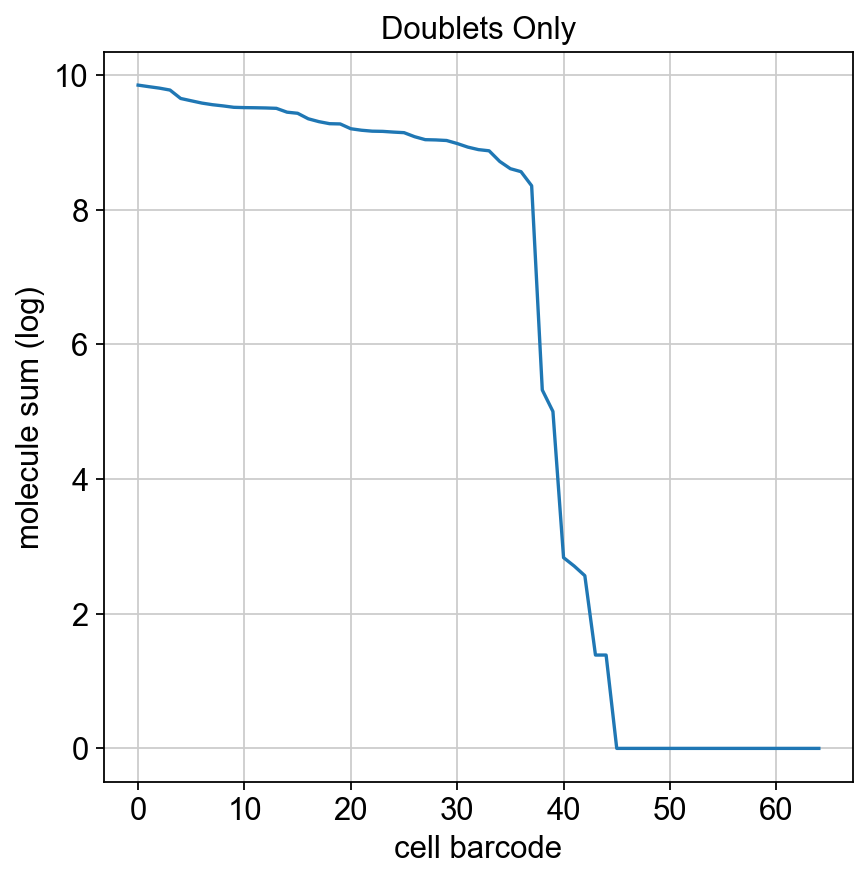

In [93]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

ax.plot(
    range(0, adata_sorted[mask_doublet].shape[0]),
    np.log(adata_sorted[mask_doublet].obs["total_umis"] + 1)
)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.set_title("Doublets Only")

plt.show()

In [94]:
# doublet only, total_umis < 10
adata_sorted[mask_doublet & (adata_sorted.obs["total_umis"] < 10)].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CATCAAGAGAATTGTG                      1                      1   
TCTATCATCTCAGCGA                      2                      0   
CATCCACCACCTCGTT                      0                      0   
ATAGACCTCGGTGTTA                      0                      0   
CCGGTAGTCACGACTA                      0                      0   
TGGGCGTGTGAGTGAC                      0                      0   
GGGAGATCAGTTTACG                      0                      0   
CGAGGAAGTGGACCTC                      0                      0   
TGTTCCGGTAAGTGTA                      0                      0   
TCACAAGTCAACTCTT                      0                      0   
GTCGTAATCTGGCCTC                      0                      0   
ATTCTACGTGAGCGAT                      0                      0   
CTACATTCAGGGATTG                      0                      0   
ATGCGATCATGAAGTA                      0                      0   
TTAGGCAGTTCTCATT                      0                      0   
TTGCGTCTCCGTAGTA                      0                      0   
TTTATGCCATCCTTGC                      0                      0   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CATCAAGAGAATTGTG                      0                      0   
TCTATCATCTCAGCGA                      0                      0   
CATCCACCACCTCGTT                      0                      0   
ATAGACCTCGGTGTTA                      0                      0   
CCGGTAGTCACGACTA                      0                      0   
TGGGCGTGTGAGTGAC                      0                      0   
GGGAGATCAGTTTACG                      0                      0   
CGAGGAAGTGGACCTC                      0                      0   
TGTTCCGGTAAGTGTA                      0                      0   
TCACAAGTCAACTCTT                      0                      0   
GTCGTAATCTGGCCTC                      0                      0   
ATTCTACGTGAGCGAT                      0                      0   
CTACATTCAGGGATTG                      0                      0   
ATGCGATCATGAAGTA                      0                      0   
TTAGGCAGTTCTCATT                      0                      0   
TTGCGTCTCCGTAGTA                      0                      0   
TTTATGCCATCCTTGC                      0                      0   
TTGCGTCGTAATTGGA                      0                      0   
ACGATGTCACGGCGTT                      0                      0   
TGTCCCAGTGGGTATG                      0                      0   
TAGACCAGTACGAAAT                      0                      0   
CGTCCATAGCCTTGAT                      0                      0   

                  A0305-CTTTGTCTTTGTGAG  A0306-TATGCTGCCACGGTA  
cell_barcodes                                                   
CATCAAGAGAATTGTG                      0                      1  
TCTATCATCTCAGCGA                      0                      1  
CATCCACCACCTCGTT                      0                      0  
ATAGACCTCGGTGTTA                      0                      0  
CCGGTAGTCACGACTA                      0                      0  
TGGGCGTGTGAGTGAC                      0                      0  
GGGAGATCAGTTTACG                      0                      0  
CGAGGAAGTGGACCTC                      0                      0  
TGTTCCGGTAAGTGTA                      0                      0  
TCACAAGTCAACTCTT                      0                      0  
GTCGTAATCTGGCCTC                      0                      0  
ATT

In [95]:
# doublet only, total_umis >= 10
adata_sorted[mask_doublet & (adata_sorted.obs["total_umis"] >= 10)].to_df()

A0301-ACCCACCAGTAAGAC  A0302-GGTCGAGAGCATTCA  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                   7370                     12   
GACTCTCGTGCACAAG                   2944                  15437   
TTCCTAAGTAGGCAGT                   9366                     11   
TTGAACGTCAGCCTCT                   5350                     24   
GTCCTCACACGGTCTG                   5607                     10   
GCCATTCAGTCATGAA                   5664                     13   
TTGTTGTCACTGCATA                   7733                     10   
TTCCGGTTCAACTACG                   6242                     11   
ATTCAGGTCACGGGCT                     25                     16   
GATGCTACAAGCCTGC                   7192                      5   
CGCCAGAGTTGTTGCA                     17                     17   
GGCTTGGCAGAGATTA                     21                     25   
GATAGCTAGCGATGAC                     10                     13   
GGTAATCGTACCAGAG                   7549                      6   
TCTACATCAACTACGT                   6731                     12   
ACAGAAAAGCAGGCAT                   8655                      6   
ATTCAGGTCTCATAGG                   5156                      9   
CAACGGCCATCCGGTG                   5455                      9   
CTCCAACCAACTGTGT                   4698                     12   
ACTGTCCAGGGTGAGG                   6359                      8   
GGCAGTCTCTTCGGTC                   4522                     24   
AACGTCACACTTCAAG                   4773                      7   
CAAAGAAGTGGGCTTC                   5978                      5   
AAAGGATGTTGACTAC                   4069                      7   
AATTTCCAGGATACAT                   5702                     10   
GGGCGTTCACCGTCTT                   4210                      3   
CTCCCTCGTCGCTCGA                   8465                      2   
CTTAGGACATCGTGCG                   7149                      3   
GCGTTTCGTTAGAGTA                   2516                     15   
TTCCTTCCACAACGAG                   1899                      9   
AGACTCACAGAATGTA                   4327                      7   
AAACGAACAGCAGTGA                   1805                      6   
GTCGCGAAGGCCTGCT                   4518                      5   
TCAGGTAAGCCGAACA                    966                      9   
TTCTTCCAGCGCCGTT                    420                      5   
GCACGTGAGTAAGACT                    354                     12   
TAAGTCGTCTAAGCGT                    325                      1   
TTTCACACAGCTATAC                    257                      8   
TTGGATGAGGGACACT                    178                      0   
AGACTCAGTAGCGTTT                    124                      1   
CACACAAAGTGGGAAA                      5                      0   
CCTTCAGCAGGCACTC                      9                      0   
GTAATGCAGGATTTAG                      7                      0   

                  A0303-CTTGCCGCATGTCAT  A0304-AAAGCATTCTTCACG  \
cell_barcodes                                                    
CGTGAATTCGGTAGAG                      3                  11565   
GACTCTCGTGCACAAG                      2                      1   
TTCCTAAGTAGGCAGT                   8739                      8   
TTGAACGTCAGCCTCT                      1                      1   
GTCCTCACACGGTCTG                      2                      1   
GCCATTCAGTCATGAA                      1                      1   
TTGTTGTCACTGCATA                      4                      0   
TTCCGGTTCAACTACG                      3                      1   
ATTCAGGTCACGGGCT                      0                   8729   
GATGCTACAAGCCTGC                      0                      3   
CGCCAGAGTTGTTGCA                   8491                      8   
GGCTTGGCAGAGATTA                   8098                     12   
GATAGCTAGCGATGAC                      2                   9439   
GGTAATCGTACCAGAG                      1                  

## Max vs. Rest Sum

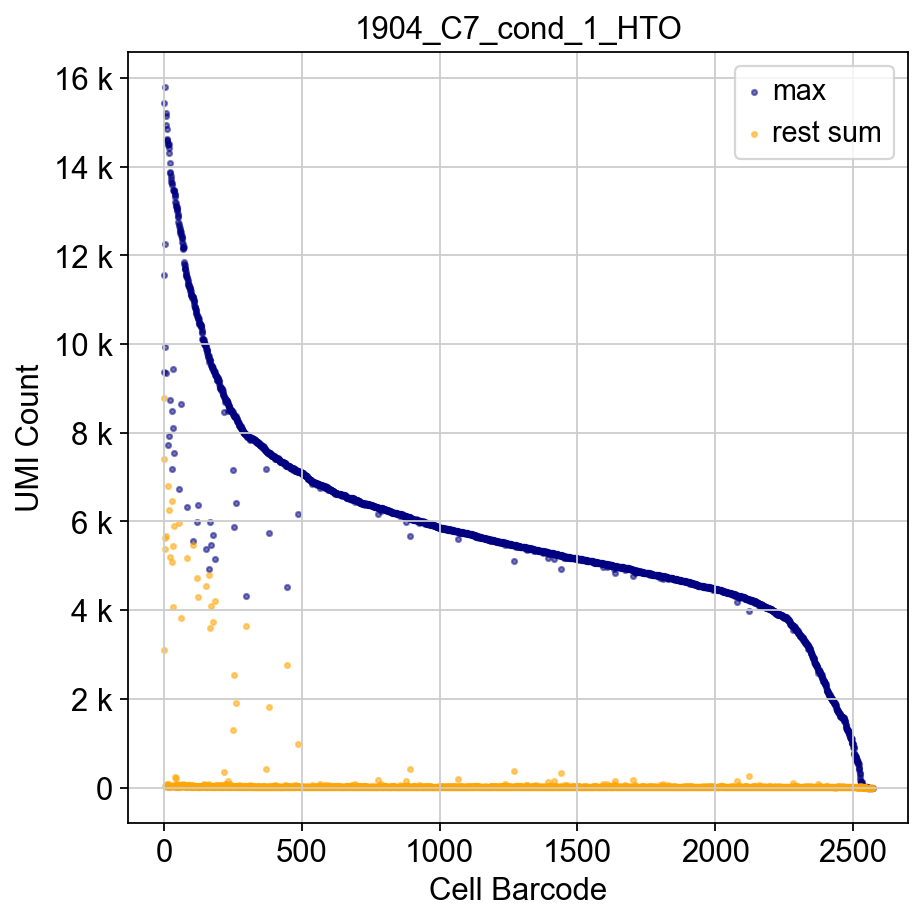

In [96]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

df_sorted = pd.DataFrame(
    np.vstack(adata_sorted.to_df().apply(
        lambda row: sorted(row, reverse=True), axis=1)
    ),
    index=adata.obs_names
)
dfx = df_sorted.copy()
dfx = dfx.assign(rest=df_sorted.iloc[:, 1:].sum(axis=1))
dfx = dfx.assign(maxx=df_sorted.max(axis=1))

ax.scatter(
    range(len(dfx)),
    dfx.maxx,
    c="navy", s=5, alpha=0.5, label="max"
)
ax.scatter(
    range(len(dfx)), dfx.rest,
    c="orange", s=5, alpha=0.5, label="rest sum"
)
ax.set_xlabel("Cell Barcode")
ax.set_ylabel("UMI Count")
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.legend()
ax.set_title(sample_name)

plt.tight_layout()
plt.show()

## Classifiy Negatives Using Inflection Points

In [97]:
def find_inflection_points(umi_sum, window_size=10, window_size2=10):
    
    # skip the first ten points
    umi_sum = umi_sum[10:]
    
    if window_size > 0:
        ms2 = pd.Series(umi_sum).rolling(window_size).mean()
    else:
        ms2 = umi_sum

    d1 = np.diff(ms2)

    if window_size2 > 0:
        ms3 = pd.Series(d1).rolling(window_size2).mean()
        d2 = np.diff(ms3)
    else:
        d2 = np.diff(d1)

    # throw out an extra 5% of cells from where the inflection point is found.
    # these cells are empirically determined to have "transition" library sizes
    # that confound downstream analysis

    inflection_pts = np.where(d2 == 0)[0]

    if len(inflection_pts) == 0:
        # no points have 2nd derivate=0
        # remove nan, abs, and find the one that is most close to zero
        # sort in asending order and pick the first five
        print("plan B")
        inflection_pts = np.argsort(d2[~np.isnan(d2)])[:10]
        inflection_pts = np.sort(inflection_pts)

    return inflection_pts, d1, d2, ms2

In [98]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def fit_linear(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    
    return y_pred, model.coef_[0], model.intercept_

def fit_polynomial(x, y):
    polynomial_features= PolynomialFeatures(degree=3)
    X = polynomial_features.fit_transform(x.reshape(-1,1))    
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    return y_pred, model.coef_, model.intercept_

plan B


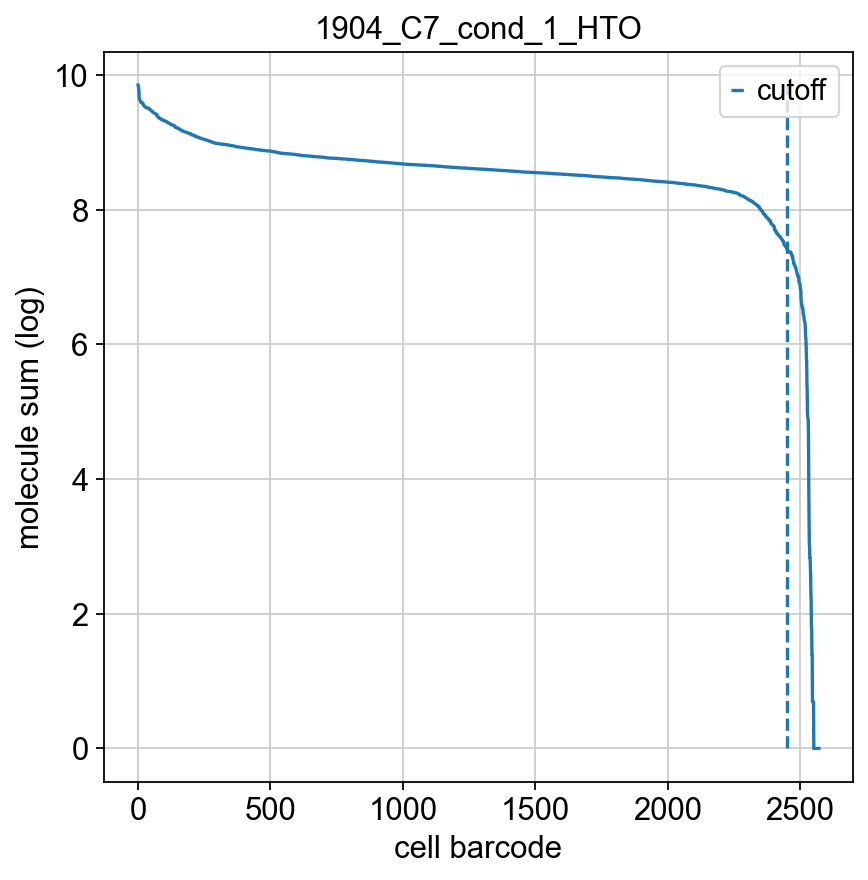

In [99]:
cutoffs = []

fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
  
x = np.array(range(0, adata_sorted.shape[0]))
ms = np.log(adata_sorted.obs["total_umis"] + 1)
inflection_pts, d1, d2, ms2 = find_inflection_points(ms, 50, 50)
y_pred, _, intercept_poly = fit_polynomial(x, ms)    
mse_poly = metrics.mean_squared_error(ms, y_pred)
_, slope, intercept_linear = fit_linear(x, ms)

#     inflection_pt = inflection_pts[0]
#     inflection_pt = inflection_pts[-1]

if intercept_poly < 4:
    inflection_pt = inflection_pts[0]
elif intercept_poly < 5 and mse_poly >= 0.2:
    inflection_pt = inflection_pts[0]
else:
    if slope < -0.003:
        # fixme: we have no good inflection points     
        inflection_pt = int(adata_sorted.shape[0] * 0.95)
    else:
        # 95% point
        inflection_pt = inflection_pts[int(len(inflection_pts)*0.99)]

cutoffs.append(inflection_pt)

ax.plot(range(0, adata_sorted.shape[0]), ms)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.vlines(
    x=inflection_pt,
    ymin=0,
    ymax=np.log(adata_sorted.obs["total_umis"].max()),
    linestyle='--', label="cutoff"
)
ax.set_title(sample_name)
ax.legend()

plt.show()

In [100]:
inflection_pt

2449

In [101]:
inflection_pts

array([2437, 2438, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449])

In [102]:
adata2 = adata_sorted.copy()

In [103]:
# duplicate, then later we will override if negatives are found
adata2.obs["hashID2"] = adata2.obs["hashID"]

In [104]:
adata2.obs.loc[adata2[inflection_pt:].obs_names]

unmapped_umi  unmapped_reads          barcode   hashID  \
cell_barcodes                                                              
AGAGCAGAGTGATGGC            45             113  165738986990427    A0301   
TTTCGATTCAAGTCGT            42              98  165875774254387    A0306   
CATACCCCAAGCGGAT            32              72  196654149101996    A0305   
CTGCGAGGTGCCGTTG            32              67  120778617375454    A0301   
GAATCGTAGCTAATCC            41              91  195634094009179    A0306   
...                        ...             ...              ...      ...   
TTGCGTCGTAATTGGA             0               0  169039017429213  Doublet   
ACGATGTCACGGCGTT             1               4  230600509672868  Doublet   
TGTCCCAGTGGGTATG             0               0  169012825602790  Doublet   
TAGACCAGTACGAAAT             0               0  231898636303276  Doublet   
CGTCCATAGCCTTGAT             1               6  231900127317275  Doublet   

                  total_reads  total_umis  hashID2  
cell_barcodes                                       
AGAGCAGAGTGATGGC         4775        1689    A0301  
TTTCGATTCAAGTCGT         4593        1674    A0306  
CATACCCCAAGCGGAT         5006        1672    A0305  
CTGCGAGGTGCCGTTG         4689        1661    A0301  
GAATCGTAGCTAATCC         4536        1618    A0306  
...                       ...         ...      ...  
TTGCGTCGTAATTGGA            0           0  Doublet  
ACGATGTCACGGCGTT            0           0  Doublet  
TGTCCCAGTGGGTATG            0           0  Doublet  
TAGACCAGTACGAAAT            0           0  Doublet  
CGTCCATAGCCTTGAT            0           0  Doublet  

[123 rows x 7 columns]

In [105]:
# add a new category "Negative"
# adata2.obs["hashID"] = adata2.obs["hashID"].cat.add_categories("Negative")
# adata2.obs["hashID2"] = adata2.obs["hashID2"].cat.add_categories("Negative")

In [106]:
# anything after the inflection point found, we will mark them as Negative
adata2.obs.loc[adata2[inflection_pt:].obs_names, "hashID2"] = "Negative"

In [107]:
adata2.obs

unmapped_umi  unmapped_reads          barcode   hashID  \
cell_barcodes                                                              
CGTGAATTCGGTAGAG           310             809  197281495759774  Doublet   
GACTCTCGTGCACAAG           444             995  130665363753827  Doublet   
TTCCTAAGTAGGCAGT           335             853  162004666531109  Doublet   
TTGAACGTCAGCCTCT           413            1101  200923749411564  Doublet   
ATCCATTGTCGAACAG           303             804  134379390790502    A0301   
...                        ...             ...              ...      ...   
TTGCGTCGTAATTGGA             0               0  169039017429213  Doublet   
ACGATGTCACGGCGTT             1               4  230600509672868  Doublet   
TGTCCCAGTGGGTATG             0               0  169012825602790  Doublet   
TAGACCAGTACGAAAT             0               0  231898636303276  Doublet   
CGTCCATAGCCTTGAT             1               6  231900127317275  Doublet   

                  total_reads  total_umis   hashID2  
cell_barcodes                                        
CGTGAATTCGGTAGAG        53364       18970   Doublet  
GACTCTCGTGCACAAG        54183       18541   Doublet  
TTCCTAAGTAGGCAGT        52063       18141   Doublet  
TTGAACGTCAGCCTCT        49788       17627   Doublet  
ATCCATTGTCGAACAG        47492       15832     A0301  
...                       ...         ...       ...  
TTGCGTCGTAATTGGA            0           0  Negative  
ACGATGTCACGGCGTT            0           0  Negative  
TGTCCCAGTGGGTATG            0           0  Negative  
TAGACCAGTACGAAAT            0           0  Negative  
CGTCCATAGCCTTGAT            0           0  Negative  

[2572 rows x 7 columns]

In [108]:
# before
adata2.obs.groupby("hashID").size()

hashID
A0301       745
A0302        21
A0303        25
A0304        16
A0305        40
A0306      1660
Doublet      65
dtype: int64

In [109]:
# after
adata2.obs.groupby("hashID2").size()

hashID2
A0301        715
A0302         20
A0303         24
A0304         16
A0305         25
A0306       1611
Doublet       38
Negative     123
dtype: int64

In [110]:
adata2_diff = adata2[ adata2.obs["hashID"] != adata2.obs["hashID2"] ]
adata2_diff.obs

unmapped_umi  unmapped_reads          barcode   hashID  \
cell_barcodes                                                              
AGAGCAGAGTGATGGC            45             113  165738986990427    A0301   
TTTCGATTCAAGTCGT            42              98  165875774254387    A0306   
CATACCCCAAGCGGAT            32              72  196654149101996    A0305   
CTGCGAGGTGCCGTTG            32              67  120778617375454    A0301   
GAATCGTAGCTAATCC            41              91  195634094009179    A0306   
...                        ...             ...              ...      ...   
TTGCGTCGTAATTGGA             0               0  169039017429213  Doublet   
ACGATGTCACGGCGTT             1               4  230600509672868  Doublet   
TGTCCCAGTGGGTATG             0               0  169012825602790  Doublet   
TAGACCAGTACGAAAT             0               0  231898636303276  Doublet   
CGTCCATAGCCTTGAT             1               6  231900127317275  Doublet   

                  total_reads  total_umis   hashID2  
cell_barcodes                                        
AGAGCAGAGTGATGGC         4775        1689  Negative  
TTTCGATTCAAGTCGT         4593        1674  Negative  
CATACCCCAAGCGGAT         5006        1672  Negative  
CTGCGAGGTGCCGTTG         4689        1661  Negative  
GAATCGTAGCTAATCC         4536        1618  Negative  
...                       ...         ...       ...  
TTGCGTCGTAATTGGA            0           0  Negative  
ACGATGTCACGGCGTT            0           0  Negative  
TGTCCCAGTGGGTATG            0           0  Negative  
TAGACCAGTACGAAAT            0           0  Negative  
CGTCCATAGCCTTGAT            0           0  Negative  

[123 rows x 7 columns]

In [111]:
adata2_diff.obs.groupby(["hashID", "hashID2"]).size()

hashID   hashID2 
A0301    Negative    30
A0302    Negative     1
A0303    Negative     1
A0305    Negative    15
A0306    Negative    49
Doublet  Negative    27
dtype: int64

## UMAP

In [112]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [113]:
adata2.raw = adata2

In [114]:
clr_normalize_each_cell(adata2)

AnnData object with n_obs × n_vars = 2572 × 6
    obs: 'unmapped_umi', 'unmapped_reads', 'barcode', 'hashID', 'total_reads', 'total_umis', 'hashID2'
    var: 'total_reads'
    layers: 'reads'

In [115]:
sc.pp.log1p(adata2)

In [116]:
sc.pp.neighbors(adata2)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [117]:
sc.tl.leiden(adata2, resolution=0.05, random_state=42)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [118]:
sc.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


... storing 'hashID' as categorical
... storing 'hashID2' as categorical


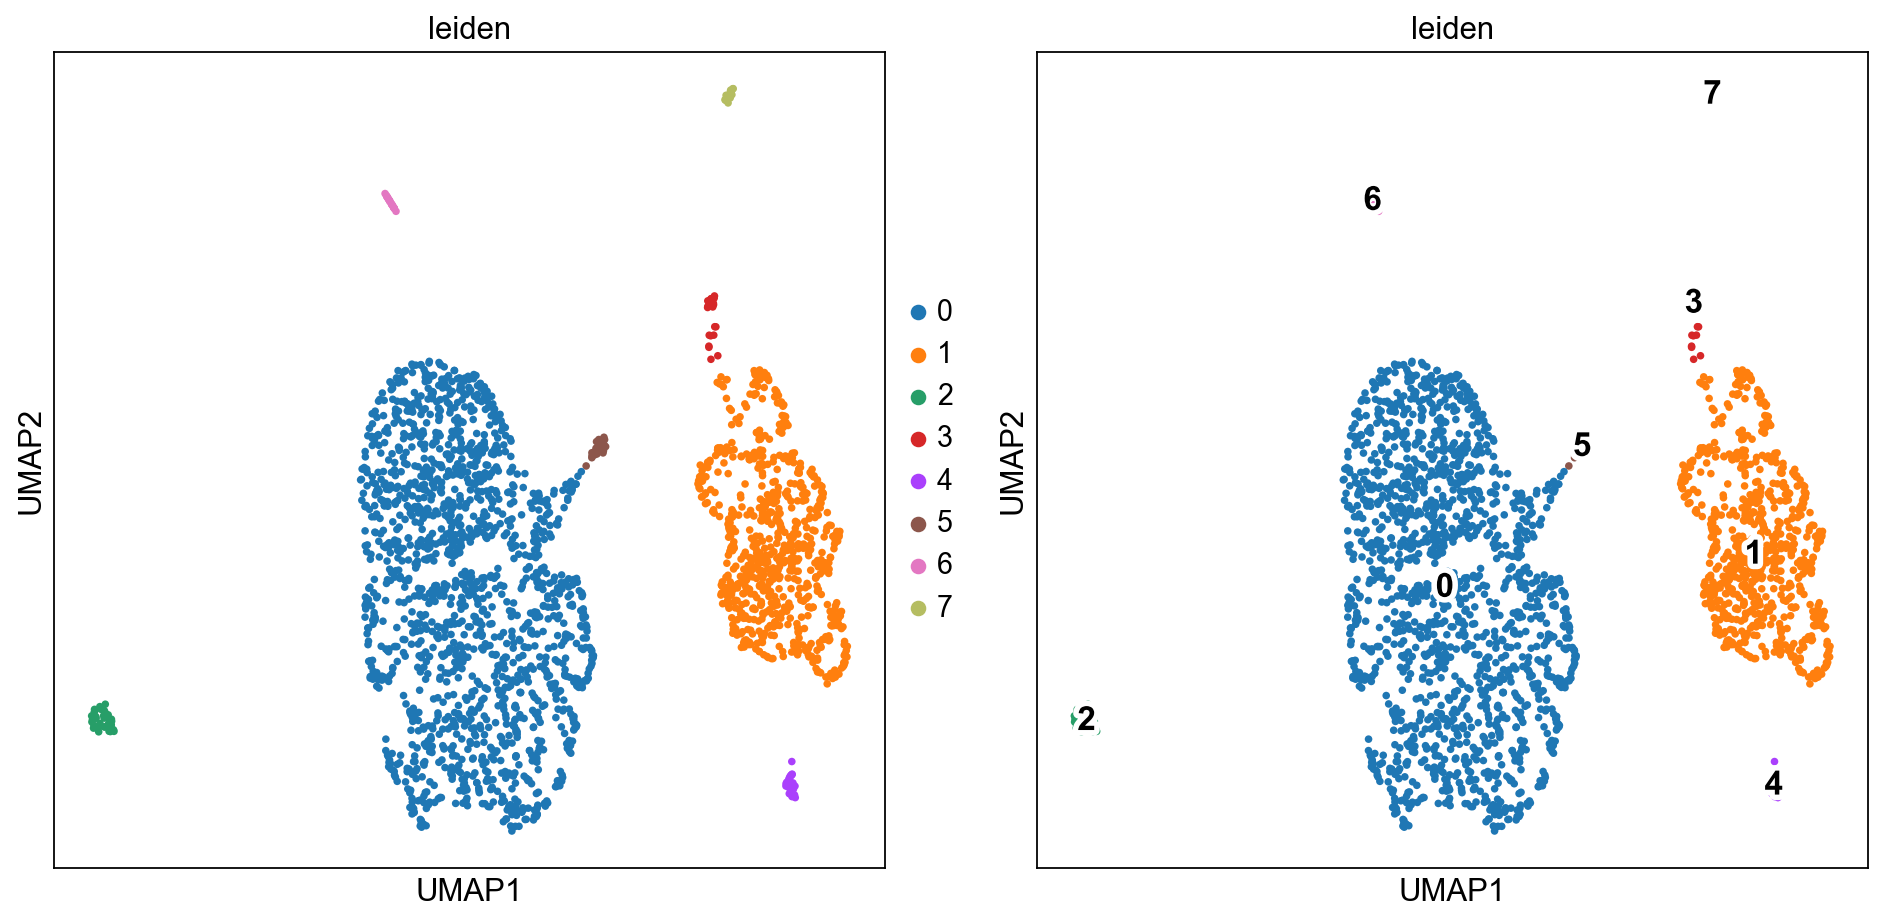

In [119]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["leiden"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["leiden"],
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

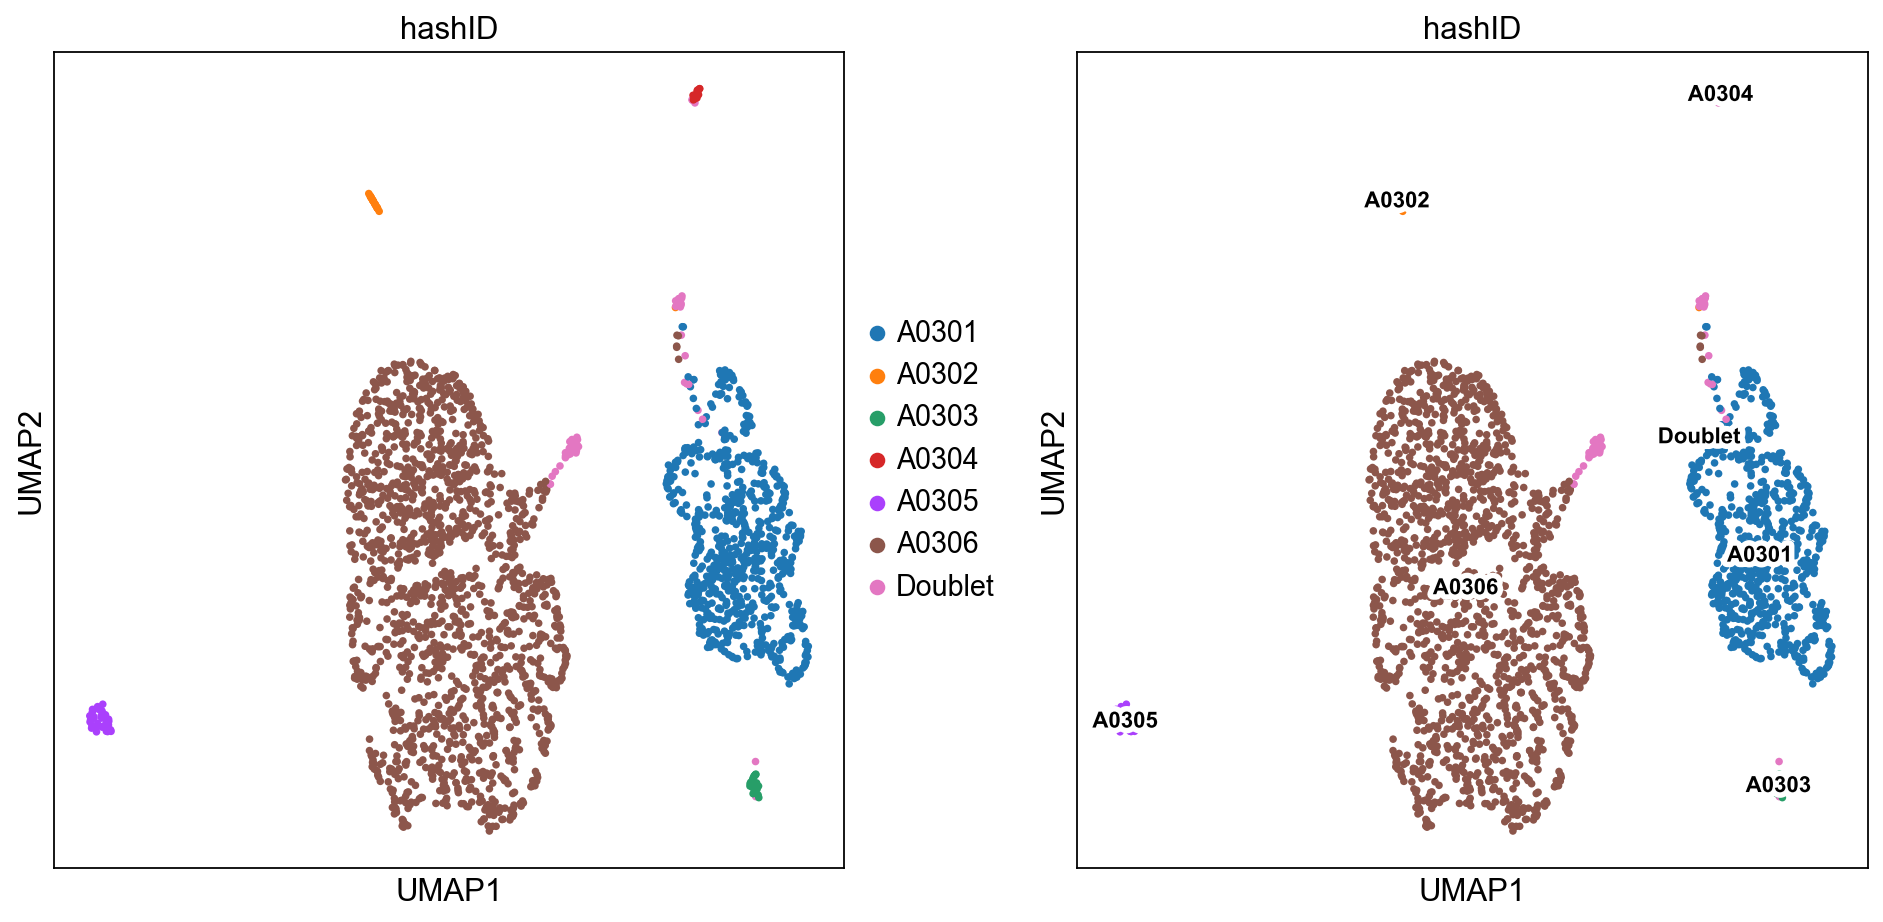

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["hashID"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["hashID"],
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

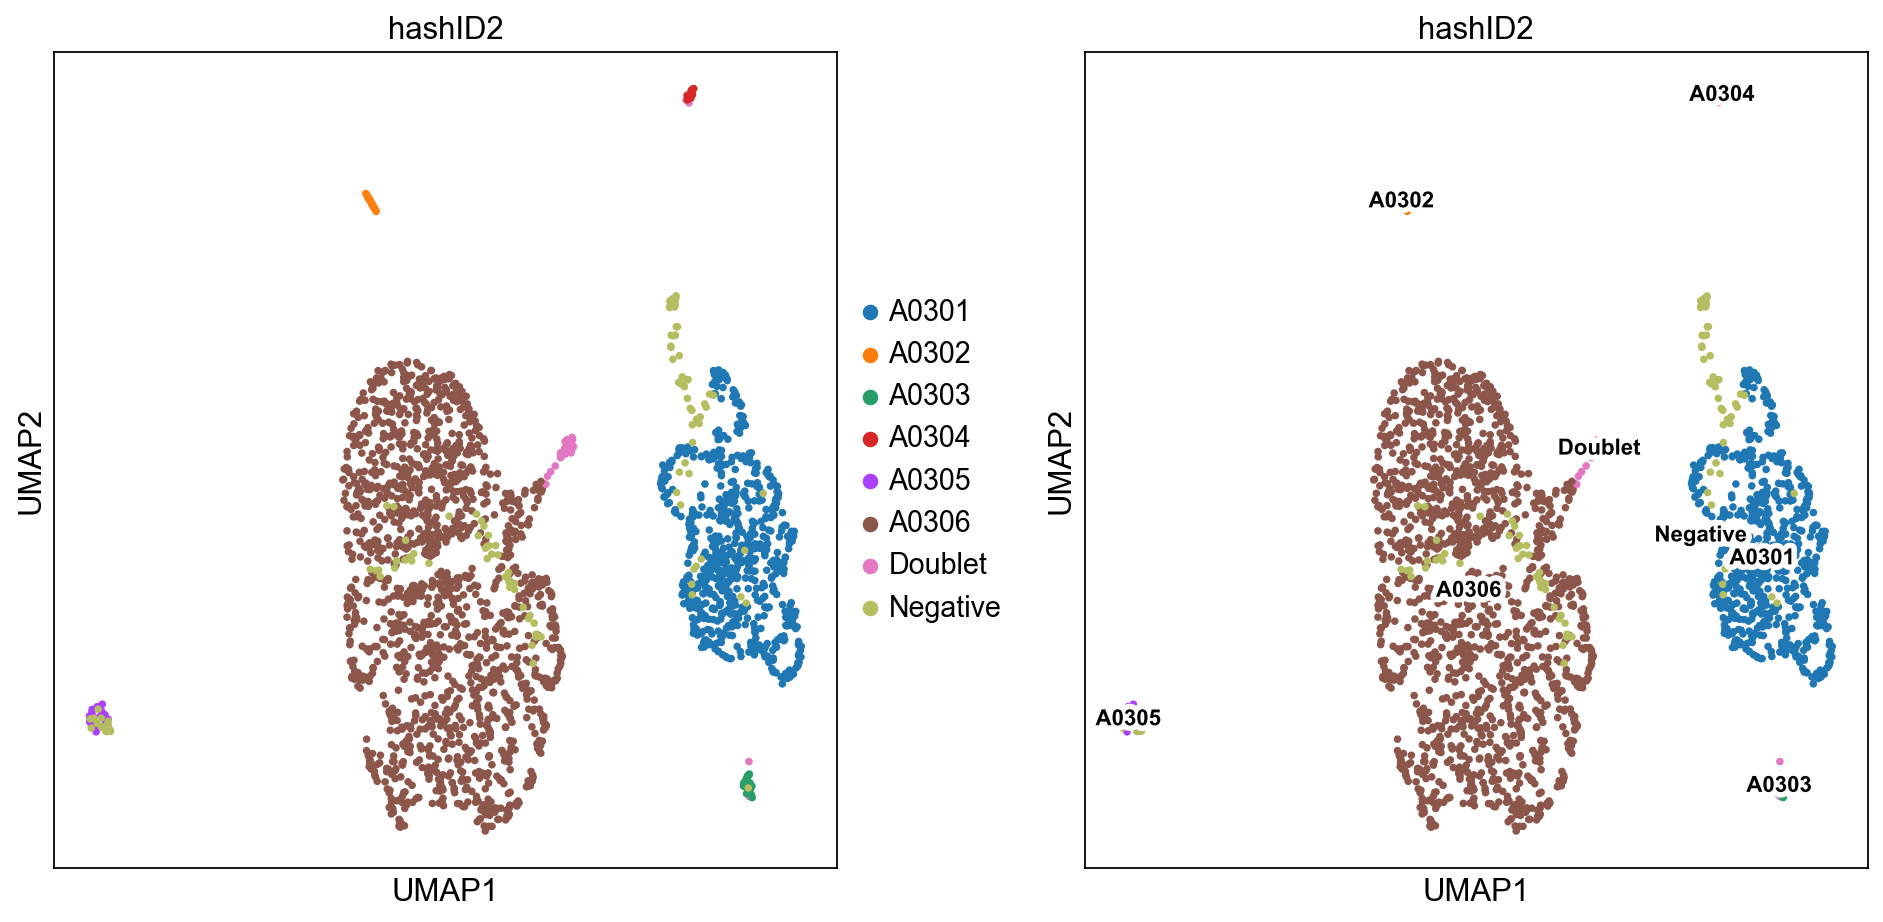

In [121]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["hashID2"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["hashID2"],
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

In [122]:
from matplotlib.colors import ListedColormap

my_cmap1 = ListedColormap(sns.color_palette("Blues").as_hex())
my_cmap2 = sns.color_palette("Paired").as_hex()
my_cmap2[0] = "lightgray"
my_cmap2 = ListedColormap(my_cmap2)

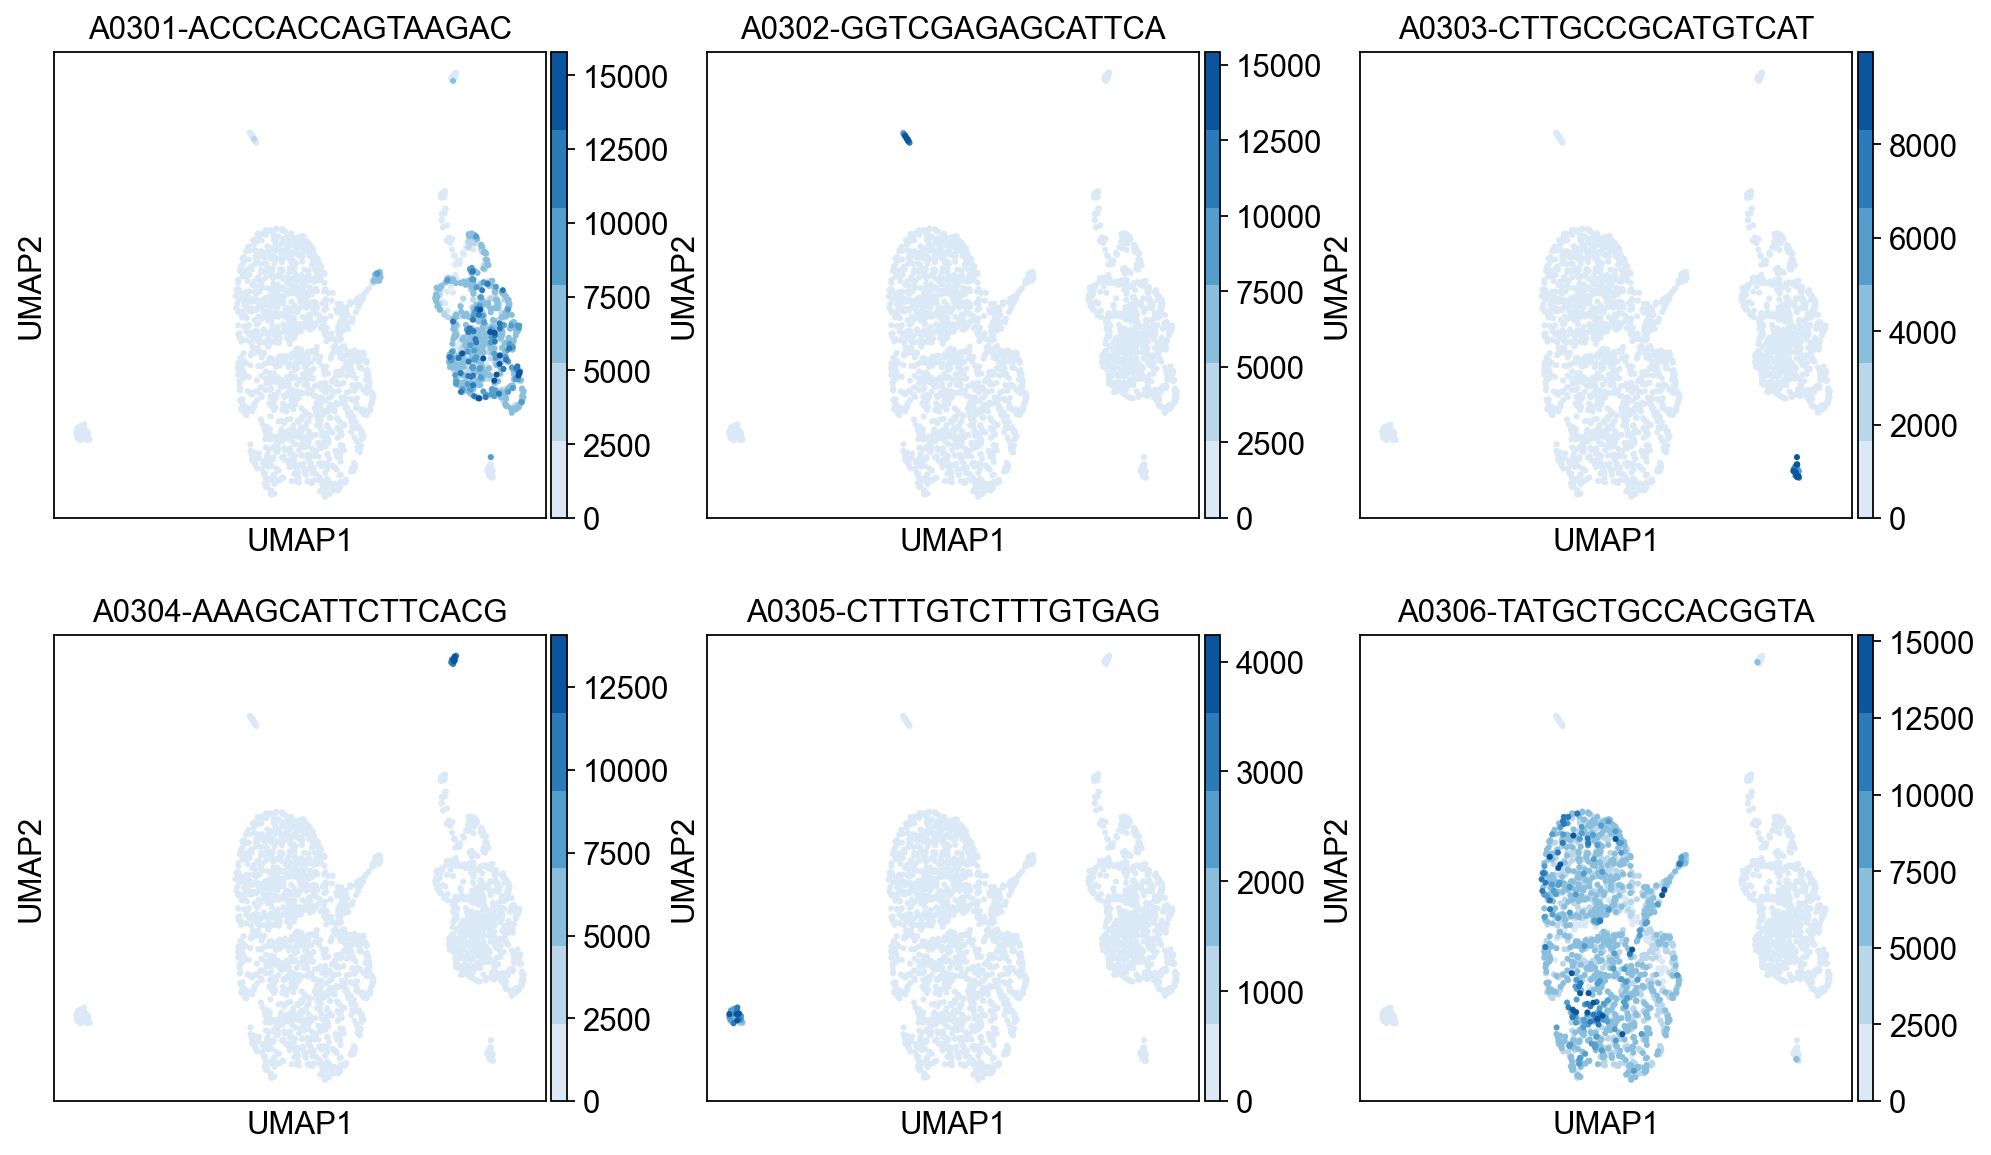

In [123]:
sc.pl.umap(
    adata2,
    color=adata2.var_names,
    color_map=my_cmap1,
    size=30,
    ncols=3,
)

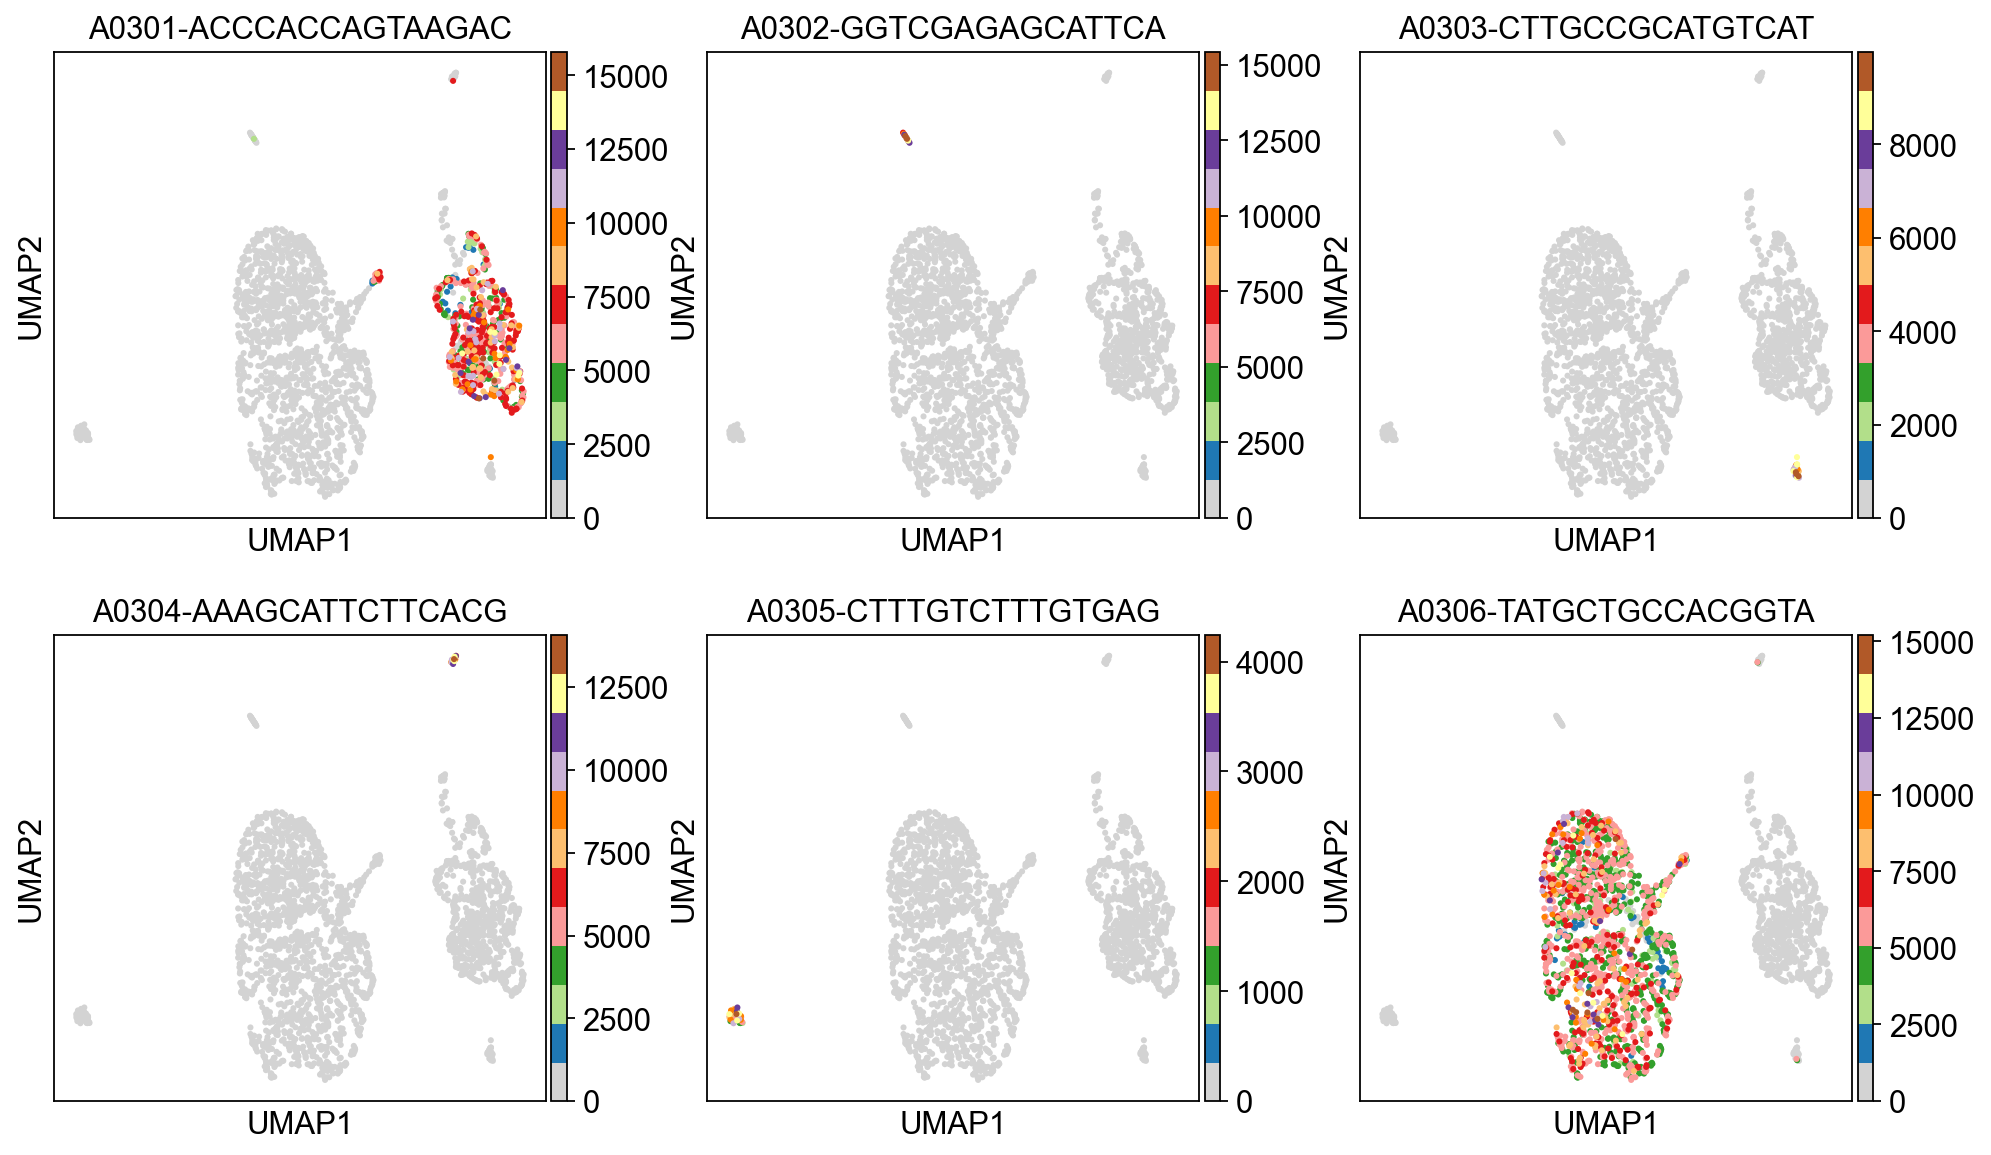

In [124]:
sc.pl.umap(
    adata2,
    color=adata2.var_names,
    color_map=my_cmap2,
    size=30,
    ncols=3,
)

## Write adata to Disk

In [125]:
adata2

AnnData object with n_obs × n_vars = 2572 × 6
    obs: 'unmapped_umi', 'unmapped_reads', 'barcode', 'hashID', 'total_reads', 'total_umis', 'hashID2', 'leiden'
    var: 'total_reads'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'hashID_colors', 'hashID2_colors'
    obsm: 'X_umap'
    layers: 'reads'
    obsp: 'distances', 'connectivities'

In [126]:
adata2.write(f"{sample_name}-qc.h5ad")